## Testing some ideas + equations about cospectral statistics.

In this notebook, we'll simulate some random numbers and explore their statistical distributions.

First, let's simulate some random numbers from a multivariate normal distributions, so that they have a correlation:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

import numpy as np

I'm going to simulate normally distributed random numbers with means of zero, and equal variances of 1 (for simplicity), and a covariance of 0.5

In [2]:
rmeans = [0,0]
rvar1 = 1.
rvar2 = 1.0
rcov = 0.5

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)

Ok, cool, what do these distributions look like?

<IPython.core.display.Javascript object>


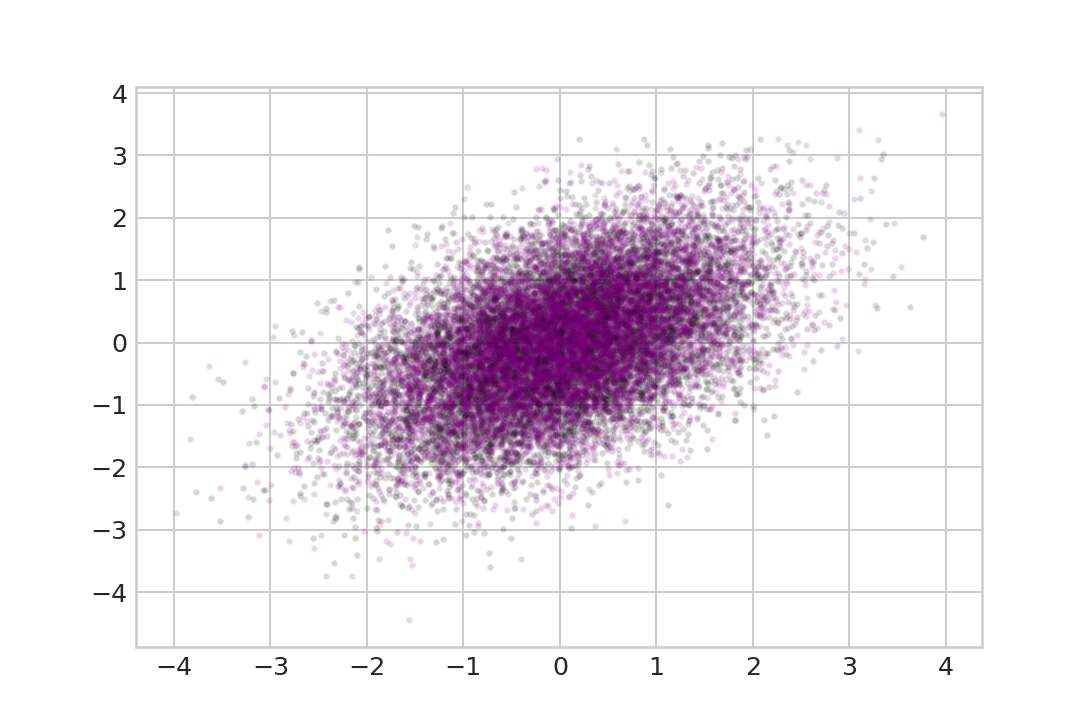

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(rsim1[:,0], rsim1[:,1], s=3, c="black", alpha=0.1)
ax.scatter(rsim2[:,0], rsim2[:,1], s=3, c="purple", alpha=0.1);

Ok, great, let's measure the covariance from the sample:

In [4]:
rcov1 = np.cov(rsim1[:,0], rsim1[:,1])

In [5]:
rcov1

array([[0.98907931, 0.48805798],
       [0.48805798, 0.99051388]])

In [6]:
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])

In [7]:
rcov2

array([[1.001188  , 0.49741173],
       [0.49741173, 0.99572443]])

That looks right! What's the Pearson moment correlation coefficient?

In [8]:
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])

In [9]:
corrcoeff1

array([[1.       , 0.4930893],
       [0.4930893, 1.       ]])

In [10]:
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

In [11]:
corrcoeff2

array([[1.        , 0.49818268],
       [0.49818268, 1.        ]])

Okay, cool, that also looks right: because my variances are 1, the correlation coefficient reduces back to the covariance. Now, let's multiply those Gaussian random numbers together:

In [12]:
rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

<IPython.core.display.Javascript object>


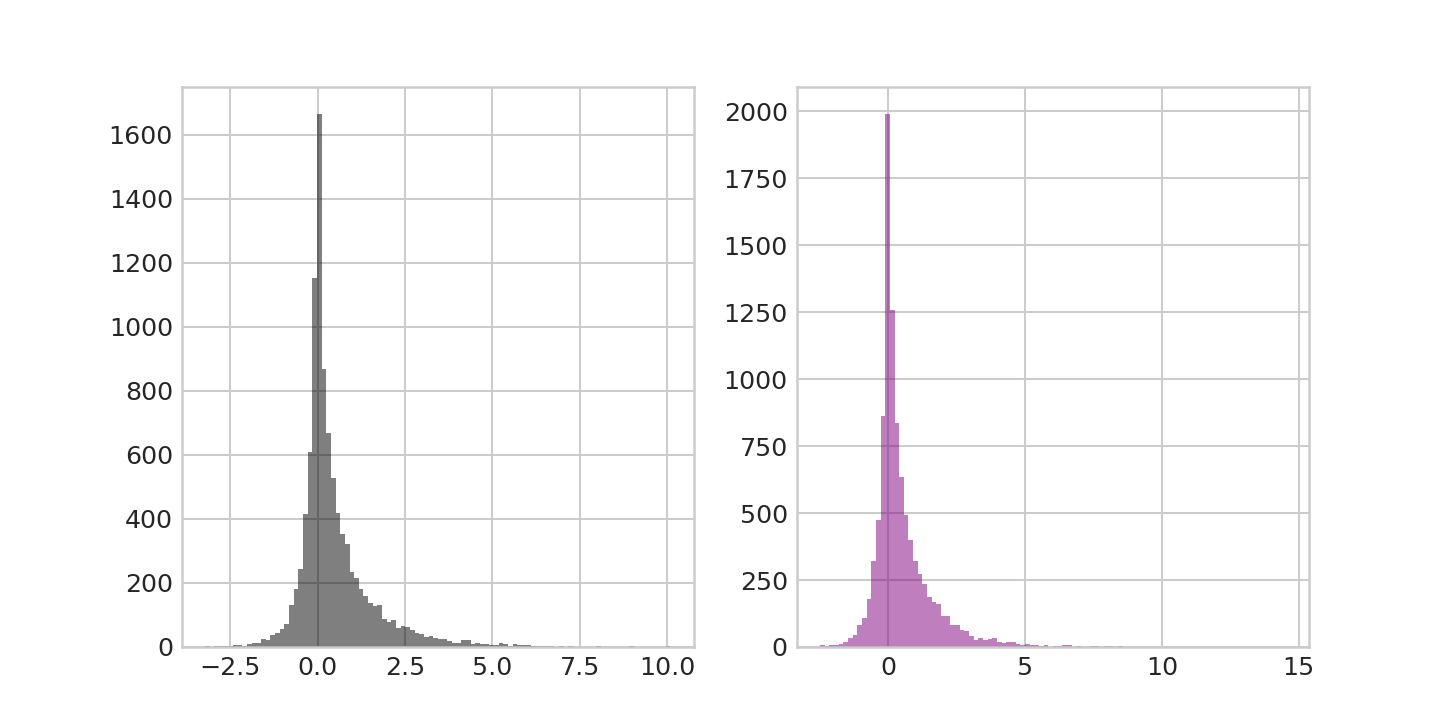

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5)
ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5);

All right, that looks like a nicely skewed distribution.

Now, let's use Equation (1) of Theorem (1) from [Gault, 2018](https://onlinelibrary.wiley.com/doi/full/10.1111/stan.12152) to calculate the PDF, defined as:

$$
f_Z(x) = \frac{1}{\pi \sigma_X \sigma_Y \sqrt{1 - \rho^2}} \exp{\left(\frac{\rho x}{\sigma_X \sigma_Y (1-\rho^2)}  \right)} K_0\left(\frac{|x|}{\sigma_X \sigma_Y (1 - \rho^2)}  \right) \; ,
$$

where $\sigma_X$ and $\sigma_Y$ are the variances of the individual random variables, $Z=XY$ is the product of the random variables, $\rho$ is the correlation coefficient between $X$ and $Y$, and $K_0$ is the modified Bessel function of the second kind of order 0.

In [14]:
import scipy.special

In [15]:
def bessel_probability(x, sigmax, sigmay, rho):
    sigmaboth = sigmax * sigmay
    rho_term = 1. - rho**2.
    
    first_term = 1. / (np.pi * sigmaboth * np.sqrt(rho_term))
    
    second_term = np.exp(rho * x / (sigmaboth * rho_term))
    
    bessel_term = np.abs(x) / (sigmaboth * rho_term)
    order = 0
    third_term = scipy.special.kv(order, bessel_term)
    return first_term * second_term * third_term

Let's actually plot that on the plot above:

In [16]:
x = np.linspace(-5, 10, 1000)

bessel_p = bessel_probability(x, np.sqrt(rvar1), np.sqrt(rvar2), rcov)

<IPython.core.display.Javascript object>


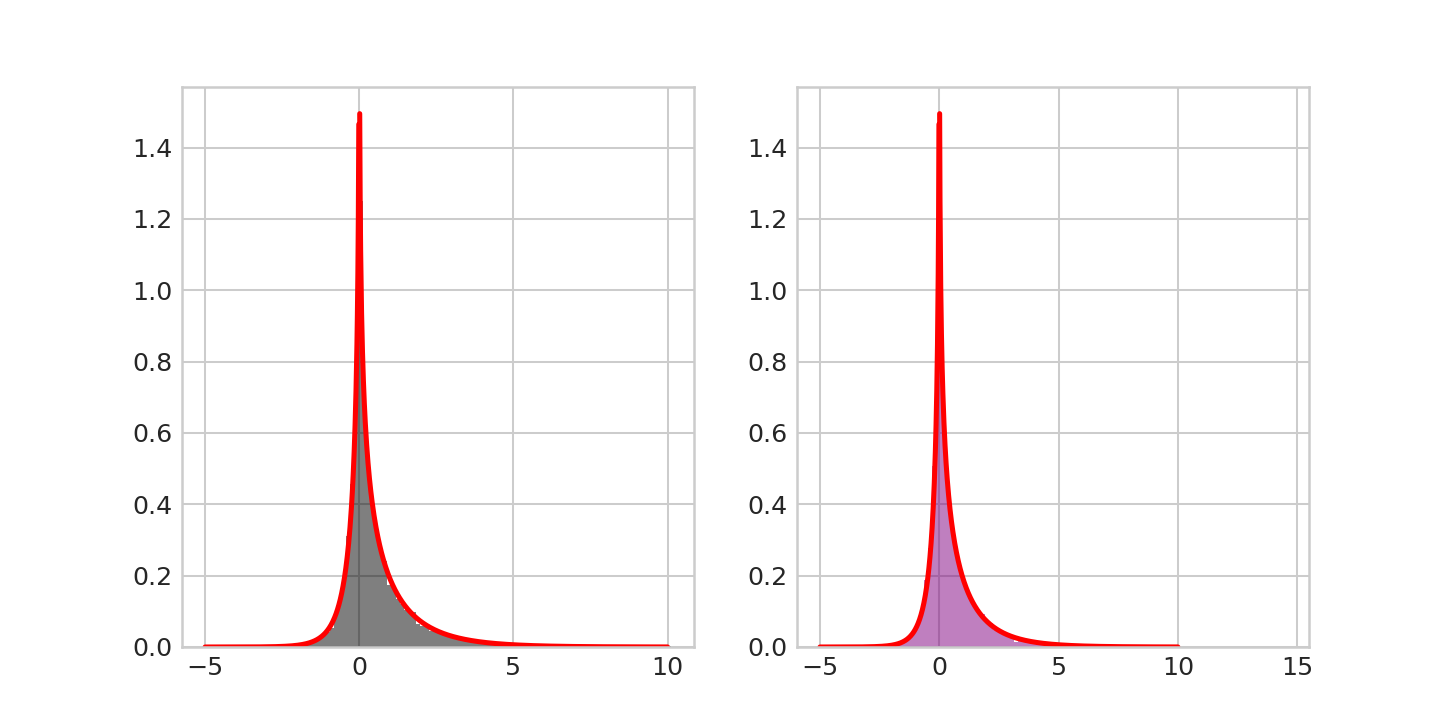

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax1.plot(x, bessel_p, lw=2, color="red")

ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
ax2.plot(x, bessel_p, lw=2, color="red")


Okay, that looks right. Excellent! Now what I'm actually interested in is the *mean* of these random variables, so let's calculate that:

In [18]:
rmean = (rmult1 + rmult2)/2.

What's the histogram of that?

<IPython.core.display.Javascript object>


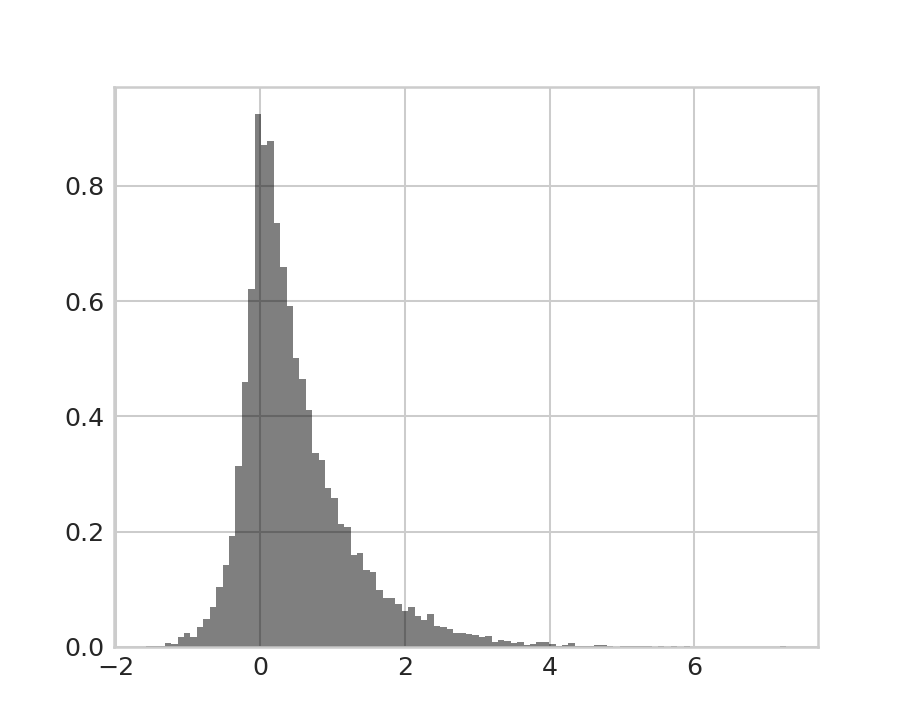

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);

That looks ... not that different, but let's write down Equation 2 from Theorem 1 of the same paper, where the sample mean of $N$ independent random variables with the same distribution as $Z$, $\bar{Z}$ = Z_1 + Z_2 + ... + Z_N$, is defined as:

$$
f_{\bar{Z}}(x) = \frac{n^{(n+1)/2} 2^{(1-n)/2} |x|^{(n-1)/2}}{(\sigma_X \sigma_Y)^{(n+1)/2}\sqrt{\pi (1 - \rho^2)} \Gamma(n/2)} \exp{\left(\frac{\rho n x}{\sigma_X \sigma_Y (1 - \rho^2)} \right)} K_{\frac{n-1}{2}}\left(\frac{n |x|}{\sigma_X \sigma_Y (1 - \rho^2)} \right) \; ,
$$

where $K_i$ is the modified Bessel function of the second kind of order $i$. Let's try to implement this function, too:

In [20]:
import mpmath

In [21]:
def mean_corr_prob(x, std1, std2, rho, n=2):
    
    sigma_both = std1 * std2
    rho_coeff = (1 - rho**2.)
    x_abs = np.abs(x)
    
    first_term_nom = (n+1)/2 * np.log(n) + (1-n)/2. * np.log(2) + (n-1)/2. *  np.log(x_abs)
    first_term_denom = ((n+1)/2.)*np.log(sigma_both) + 0.5 * np.log(np.pi * rho_coeff) + scipy.special.gammaln(n/2.)
    
    first_term = first_term_nom - first_term_denom
    
    second_term = rho * n * x / (sigma_both * rho_coeff)
    
    log_bessel_arg = np.log(n) + np.log(x_abs) -  np.log(sigma_both) - np.log(rho_coeff)
    order = (n - 1) / 2.
    
    third_term = np.log(scipy.special.kv(order, np.exp(log_bessel_arg)))
    
    tt_mask = (np.isfinite(third_term))
    
    for i in np.arange(0, len(tt_mask), 1, dtype=int)[~tt_mask]:
        third_term[i] = np.float(mpmath.log(mpmath.besselk(order, np.exp(log_bessel_arg[i]))))
    
    return np.exp(first_term + second_term + third_term)
    

In [22]:
x = np.linspace(-2.5, 7, 1000)

m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), rcov, n=2)

What does a plot of that look like?

<IPython.core.display.Javascript object>


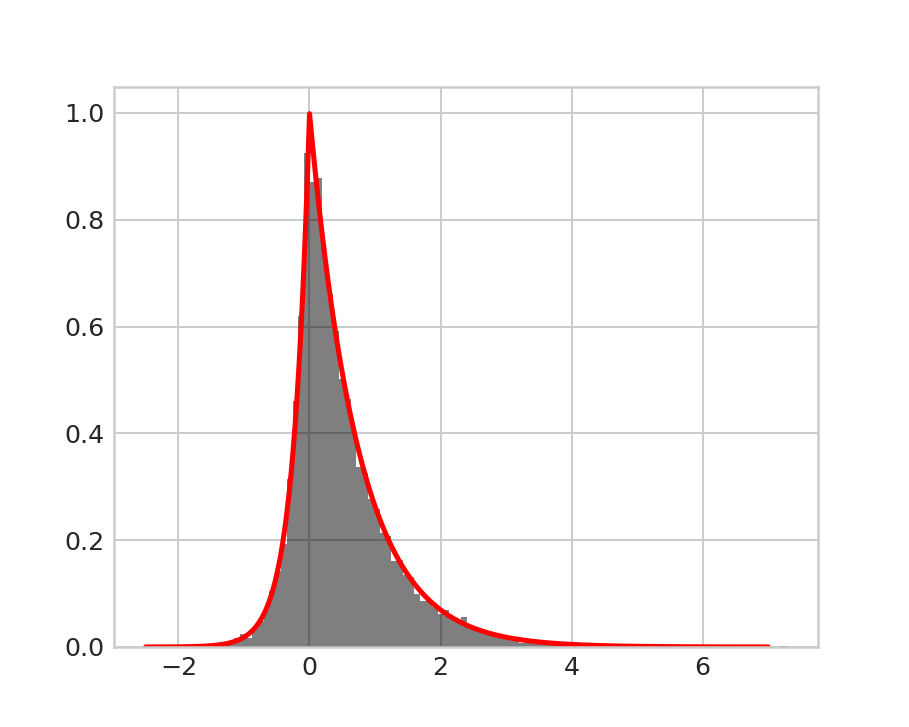

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);

ax.plot(x, m_prob, lw=2, color="red")

### Unequal variances

Let's do the same again, but with unequal variances:

In [24]:
rmeans = [0,0]
rvar1 = 1.5
rvar2 = 3.0
rcov = 0.5

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)

rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

rmean = (rmult1 + rmult2)/2.

Because the variances are now different from 1, the correlation coefficient is no longer the same as the variance:

In [25]:
corr = corrcoeff1[0,1]
print(corr)

0.25099401608841343


In [26]:

x = np.linspace(-15, 15, 1000)

bessel_p = bessel_probability(x, np.sqrt(rvar1),np.sqrt(rvar2), corr)

<IPython.core.display.Javascript object>


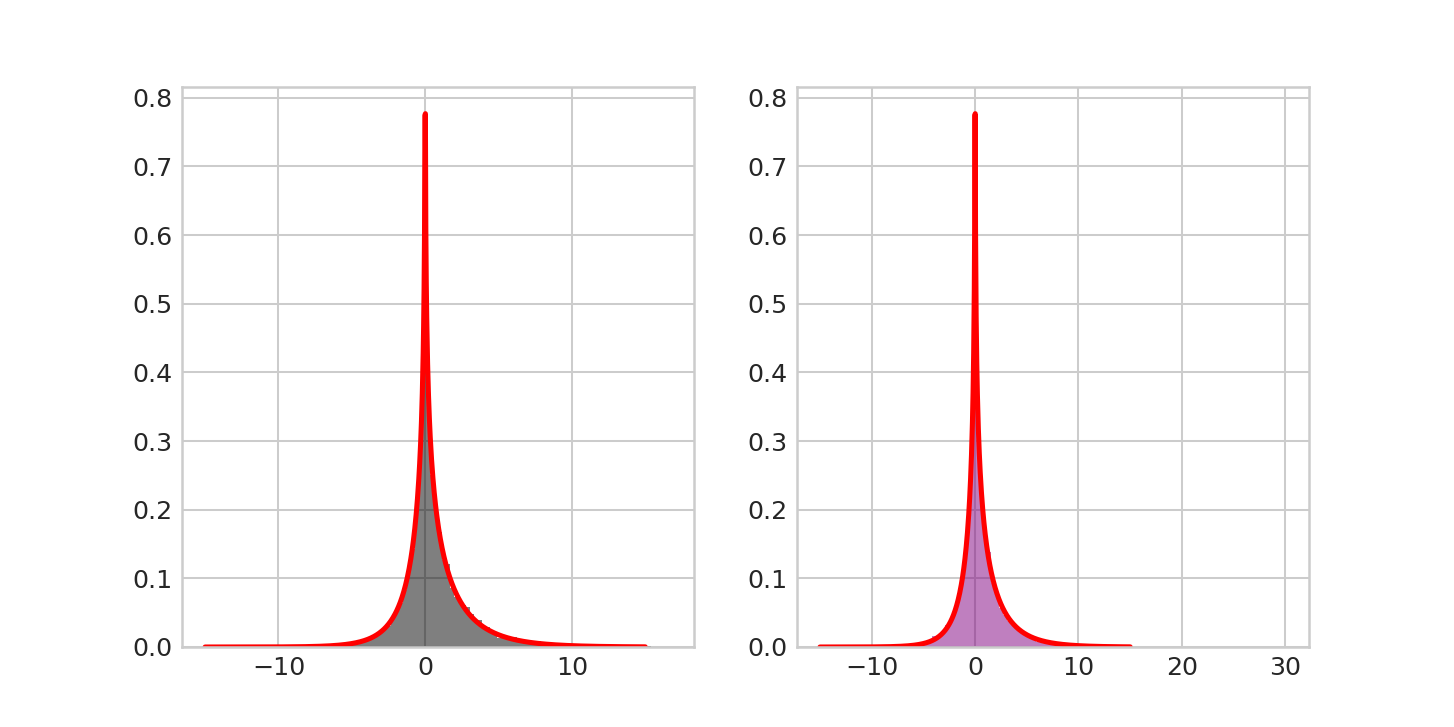

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax1.plot(x, bessel_p, lw=2, color="red")

ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
ax2.plot(x, bessel_p, lw=2, color="red")


Okay, that looks right, what about the sum of these?

<IPython.core.display.Javascript object>


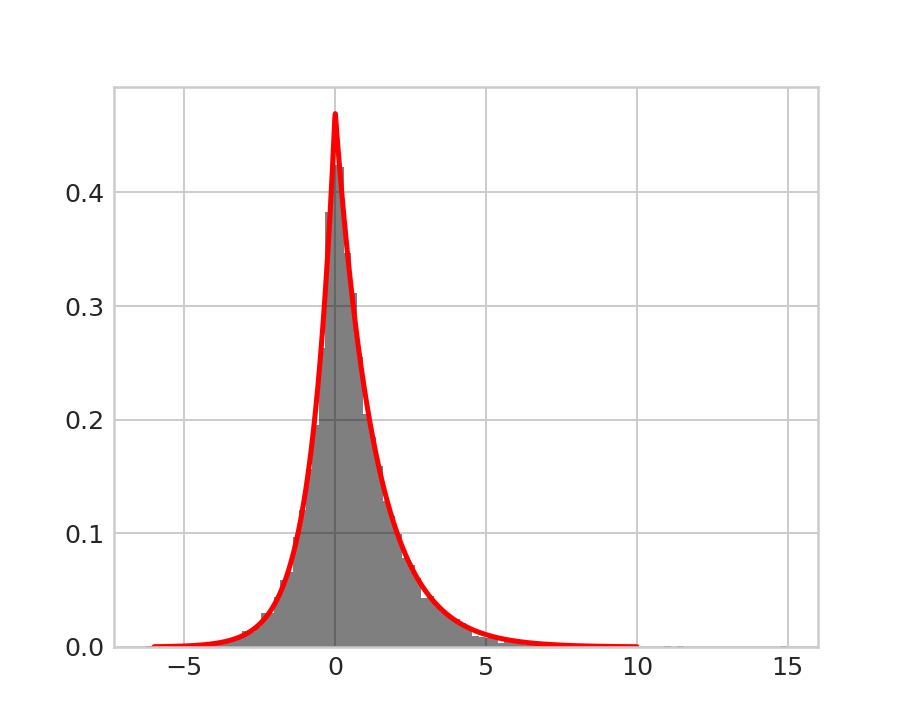

In [28]:
x = np.linspace(-6, 10, 1000)
m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax.plot(x, m_prob, lw=2, color="red")

Hooray! That also looks right! 

## Large values

What about large variances?

In [29]:
rmeans = [0,0]
rvar1 = 1500
rvar2 = 3000
rcov = 0.5

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)

rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

rmean = (rmult1 + rmult2)/2.

<IPython.core.display.Javascript object>


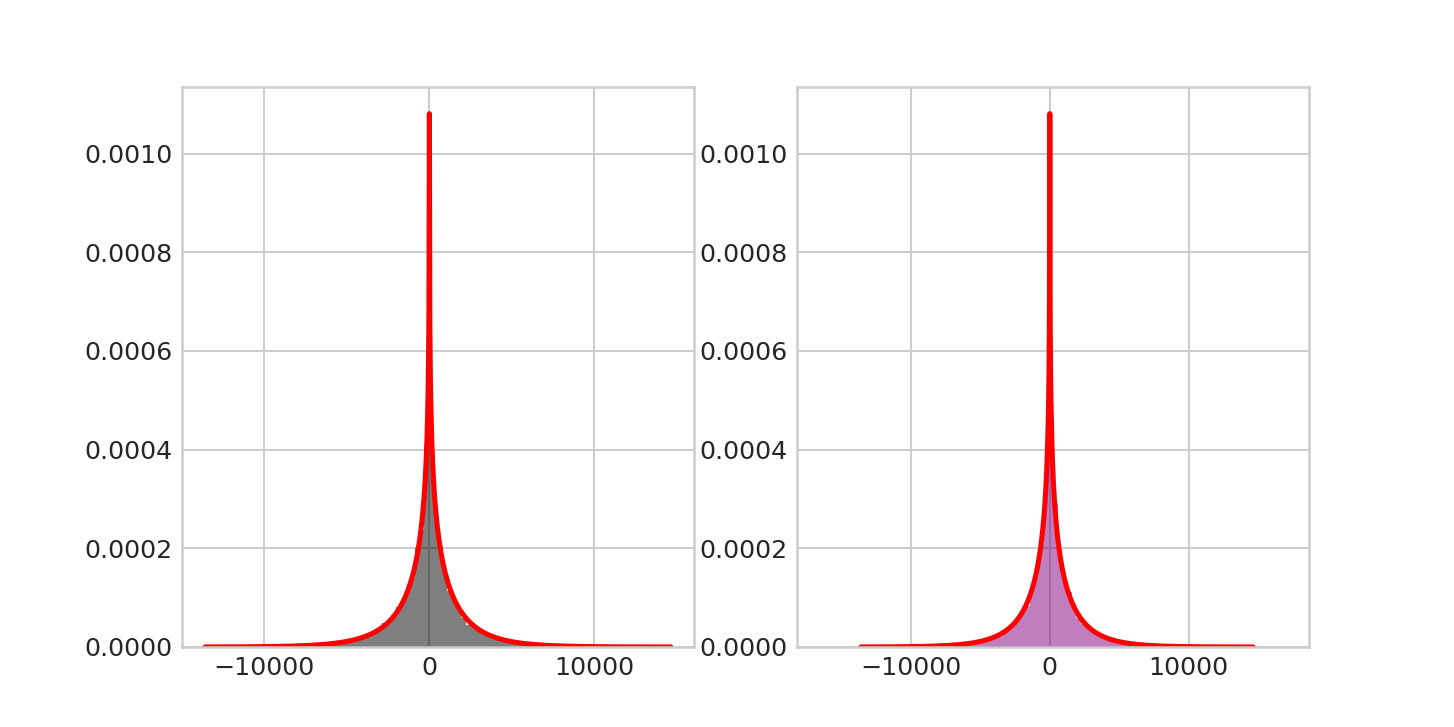

In [30]:
corr = corrcoeff1[0,1]
x = np.linspace(np.min(rmult1), np.max(rmult1), 1000)
bessel_p = bessel_probability(x, np.sqrt(rvar1),np.sqrt(rvar2), corr)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax1.plot(x, bessel_p, lw=2, color="red")

ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
ax2.plot(x, bessel_p, lw=2, color="red")


<IPython.core.display.Javascript object>


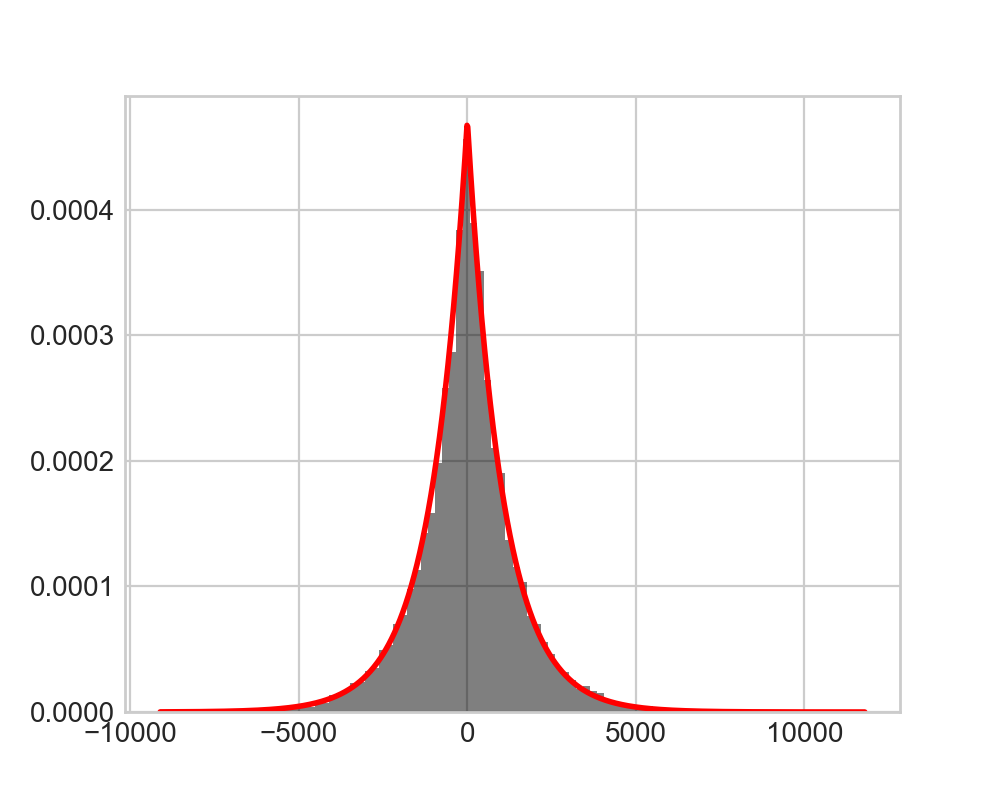

In [32]:
x = np.linspace(np.min(rmean), np.max(rmean), 1000)
m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax.plot(x, m_prob, lw=2, color="red")

That also looks right!

## Small correlation coeffient

What if the correlation coefficient is really small?

In [31]:
rmeans = [0,0]
rvar1 = 1500
rvar2 = 3000
rcov = 0.01

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)

rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

rmean = (rmult1 + rmult2)/2.

correlation coeffient: 0.011699858597526867


<IPython.core.display.Javascript object>


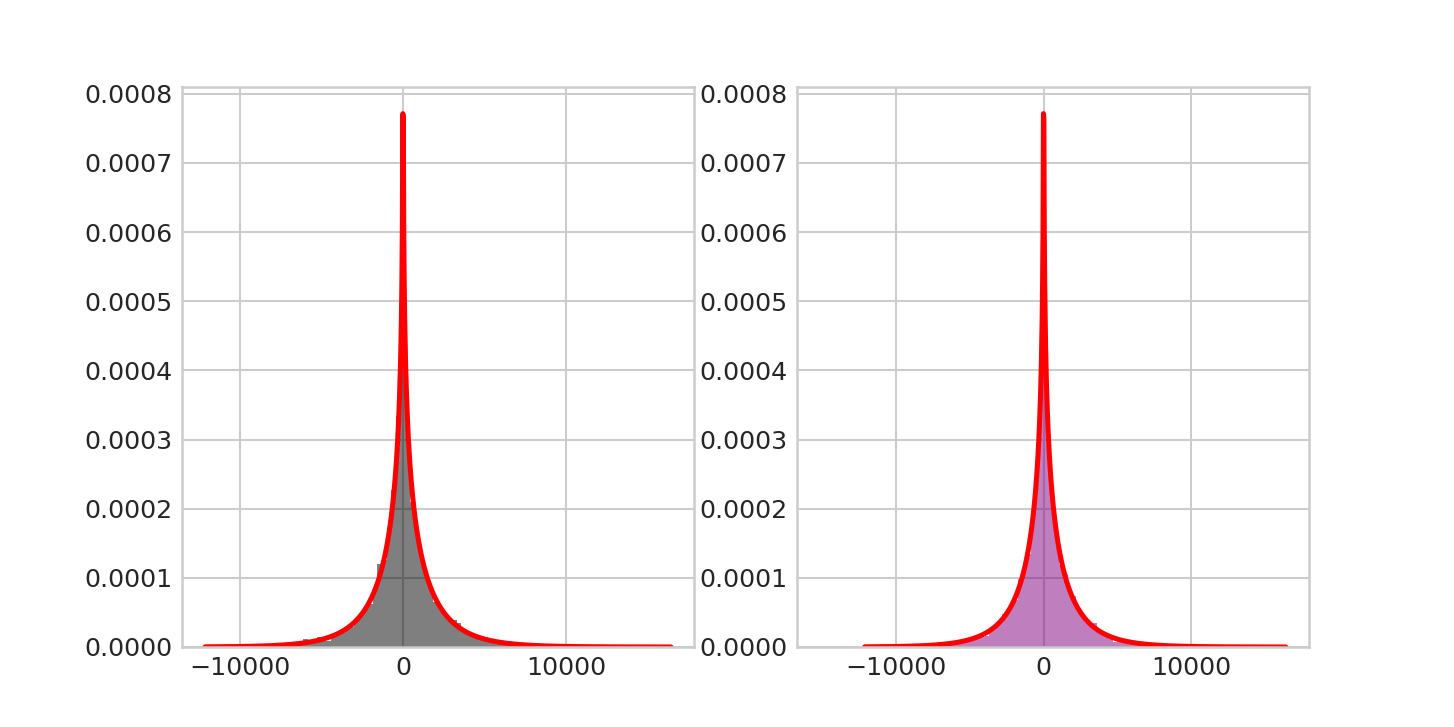

In [32]:
corr = corrcoeff1[0,1]

print("correlation coeffient: " + str(corr))

x = np.linspace(np.min(rmult1), np.max(rmult1), 1000)
bessel_p = bessel_probability(x, np.sqrt(rvar1),np.sqrt(rvar2), corr)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax1.plot(x, bessel_p, lw=2, color="red")

ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
ax2.plot(x, bessel_p, lw=2, color="red")


<IPython.core.display.Javascript object>


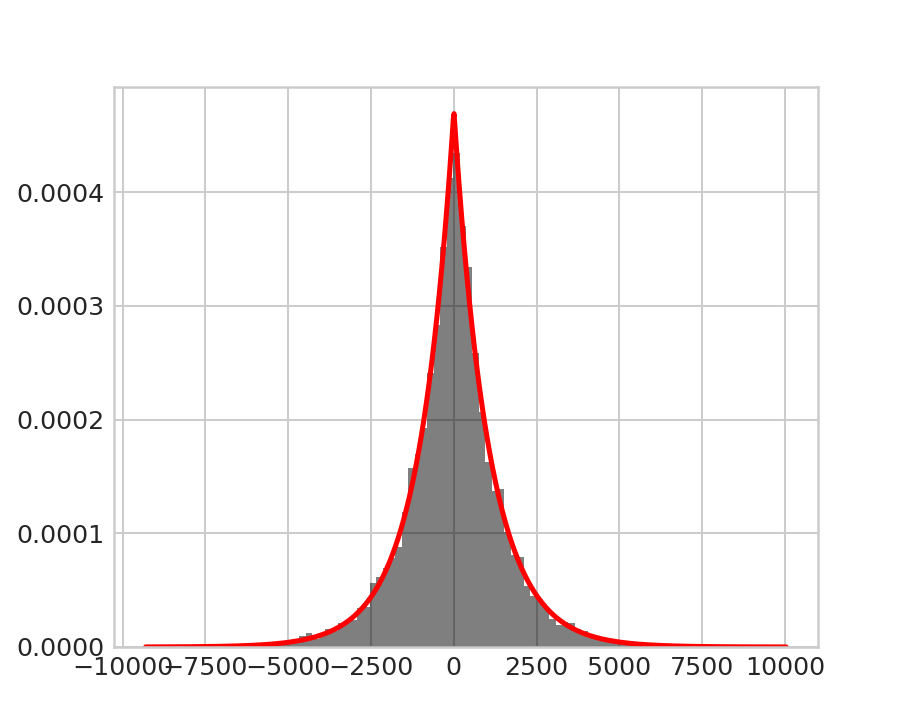

In [320]:
x = np.linspace(np.min(rmean), np.max(rmean), 1000)
m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax.plot(x, m_prob, lw=2, color="red")

## Large Correlation Coefficient

What if the correlation coefficient is really large?

In [33]:
rmeans = [0,0]
rvar1 = 8000**2.
rvar2 = 20000**2.
rcov = 13000**2.

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=10000)

rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])
corr = corrcoeff1[0,1]

rmean = (rmult1 + rmult2)/2.

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


<IPython.core.display.Javascript object>


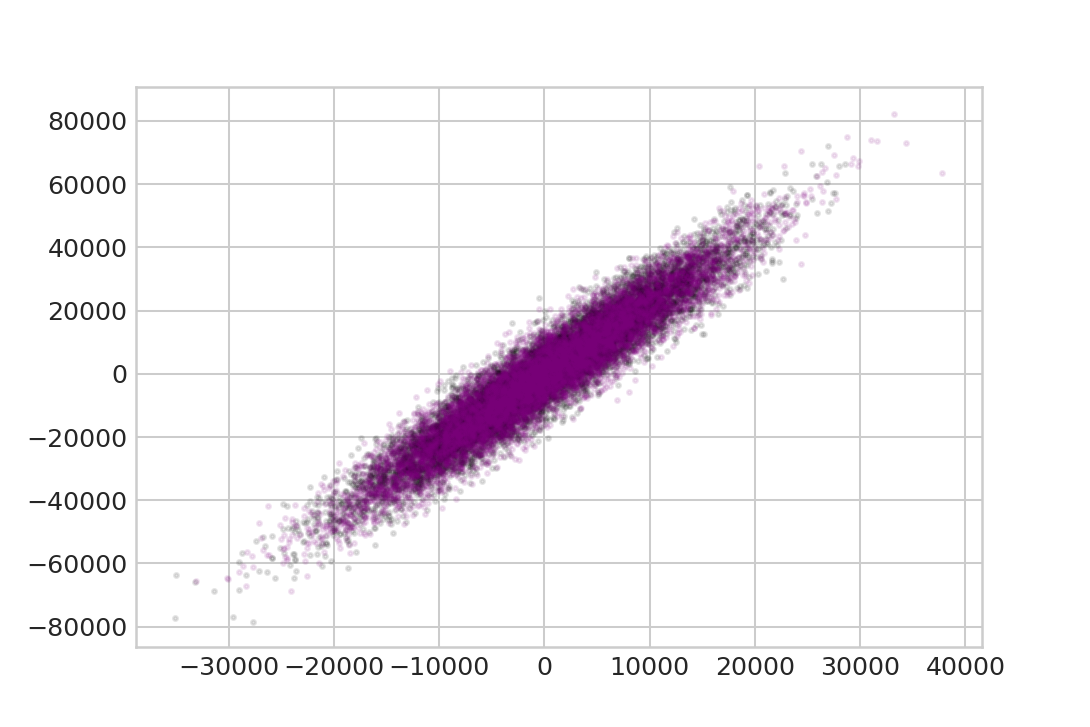

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(rsim1[:,0], rsim1[:,1], s=3, c="black", alpha=0.1)
ax.scatter(rsim2[:,0], rsim2[:,1], s=3, c="purple", alpha=0.1);

correlation coeffient: 0.9503075832172098


<IPython.core.display.Javascript object>


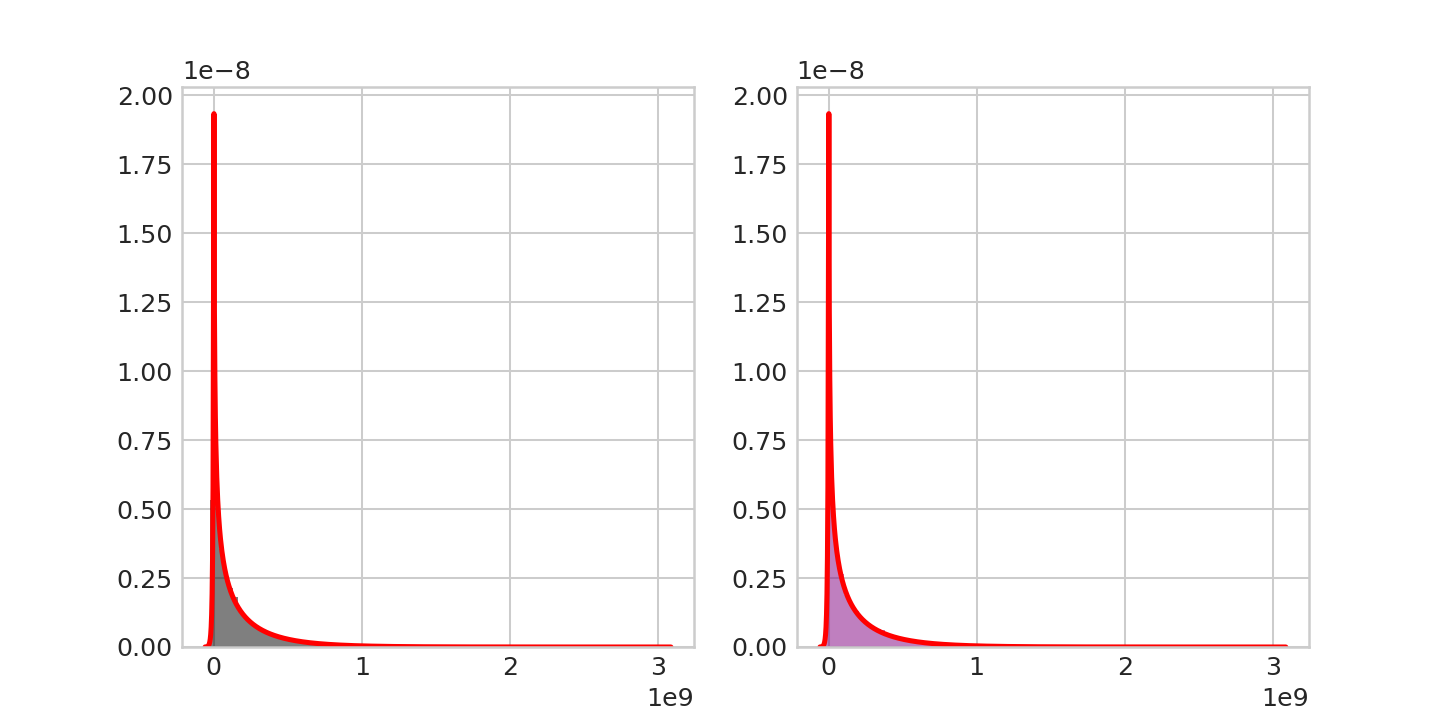

In [38]:
corr = corrcoeff1[0,1]

print("correlation coeffient: " + str(corr))

x = np.linspace(np.min(rmult1), np.max(rmult1), 1000)
bessel_p = bessel_probability(x, np.sqrt(rvar1),np.sqrt(rvar2), corr)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax1.plot(x, bessel_p, lw=2, color="red")

ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
ax2.plot(x, bessel_p, lw=2, color="red")

<IPython.core.display.Javascript object>


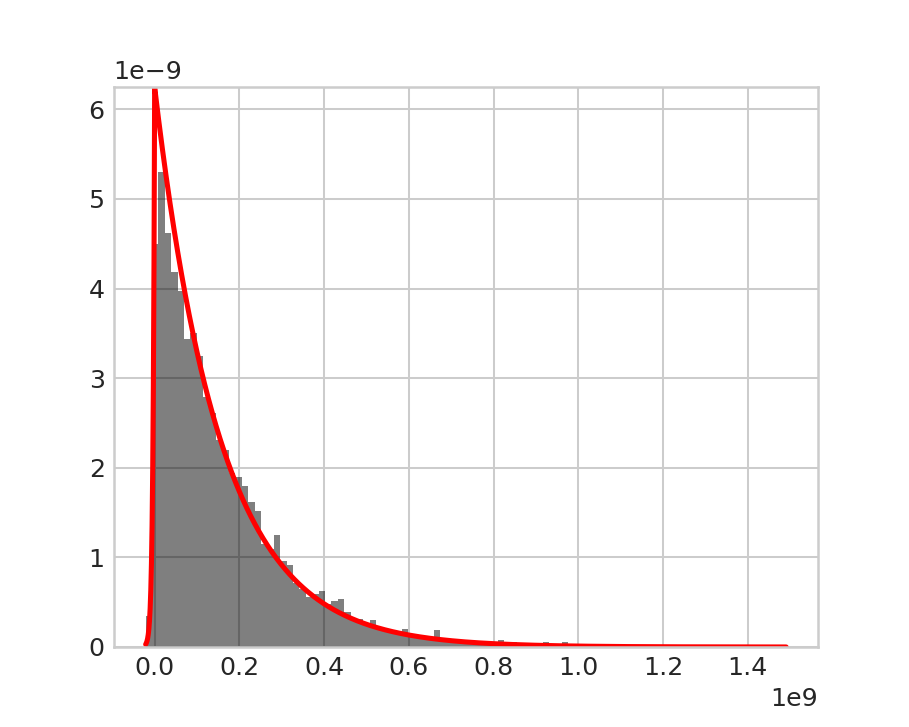

In [35]:
x = np.linspace(np.min(rmean), np.max(rmean), 1000)
m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax.plot(x, m_prob, lw=2, color="red")

Okay, that all looks right! Very good! 

# Simulated Cospectra

Now that I've convinced myself that the distributions I've programmed are correct, let's try and simulate some light curves:

In [36]:
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator

import warnings
warnings.filterwarnings('ignore')

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


The following loop just simulates a bunch of light curves from a power law PSD, using the `stingray.simulator` package, and then saves the Fourier amplitudes, the periodograms and the cospectra:

In [37]:
npoints = 2000 # number of data points
dt = 0.0001 # time step

# set the random state for reproducibility
rng = np.random.RandomState(100) 

# set up the Simulator object.
sim = Simulator(dt=dt, N=npoints, mean=100, rms=0.2, random_state=rng)

nsim = 10000 # number of simulated data sets

fourier1_all, fourier2_all, csd_all, csd_normed_all = [], [], [], []
lc1_counts_all, lc2_counts_all = [], []
lc1_all, lc2_all = [], []
ps1_all, ps2_all = [], []

for i in range(nsim):
    #print(i)
    lc = sim.simulate(2)
    
    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)
    except ValueError:
        continue
        
    lc1 = Lightcurve(lc.time, counts1)
    lc2 = Lightcurve(lc.time, counts2)
    
    lc1_counts_all.append(np.sum(lc1.counts))
    lc2_counts_all.append(np.sum(lc2.counts))
    
    lc1_all.append(lc1)
    lc2_all.append(lc2)
    
    fourier1 = scipy.fftpack.fft(lc1.counts)
    fourier2 = scipy.fftpack.fft(lc2.counts)

    freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

    fourier1 = fourier1[freqs>0][:1500]
    fourier2 = fourier2[freqs>0][:1500]

    freqs = freqs[freqs > 0]
    
    csd_real = fourier1.real * fourier2.real
    csd_imag = fourier1.imag * fourier2.imag

    csd = csd_real + csd_imag
    
    mean_nphot = np.sqrt(np.sum(lc1.counts)*np.sum(lc2.counts))

    ps1 = Powerspectrum(lc1, norm="leahy")
    ps2 = Powerspectrum(lc2, norm="leahy")
    
    ps1_all.append(ps1)
    ps2_all.append(ps2)
    fourier1_all.append(fourier1[:1500])
    fourier2_all.append(fourier2[:1500])
    csd_all.append(csd[:1500])
    csd_normed_all.append(2.*csd[:1500]/mean_nphot)


Let's plot an example of a light curve, periodogram and cospectrum:

<IPython.core.display.Javascript object>


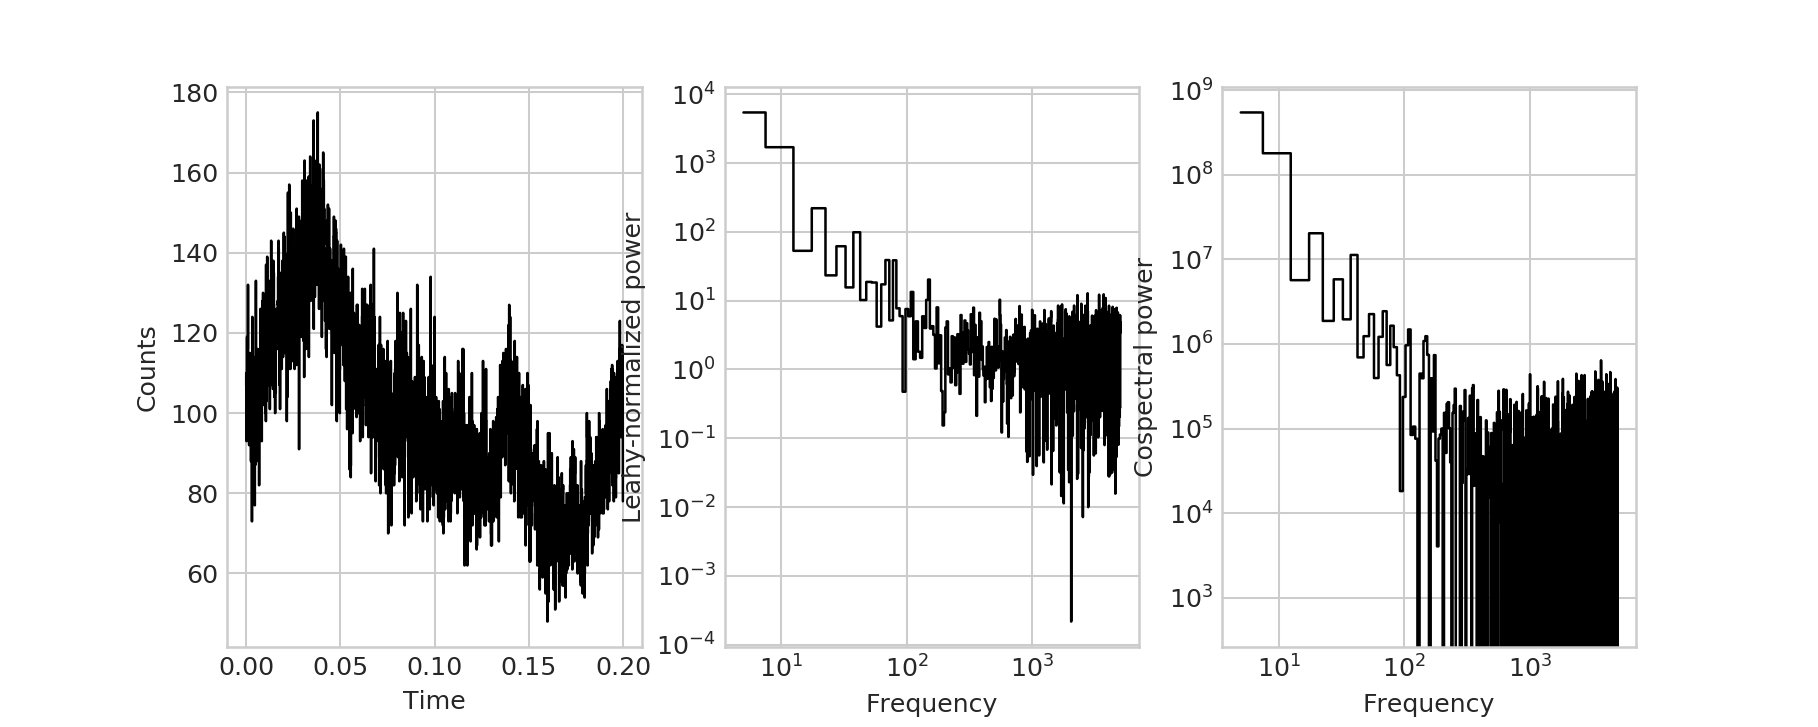

Text(0,0.5,'Cospectral power')

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

idx = 100

lc = lc1_all[idx]
ps = ps1_all[idx]

csd = csd_all[idx]

ax1.plot(lc.time, lc.counts, lw=1, color="black", linestyle="steps-mid")
ax1.set_xlabel("Time")
ax1.set_ylabel("Counts")

ax2.loglog(ps.freq, ps.power, lw=1, color="black", linestyle="steps-mid")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Leahy-normalized power")

ax3.loglog(ps.freq[:1500], csd, lw=1, color="black", linestyle="steps-mid")
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Cospectral power")

That looks like what I would expect. To estimate the actual underlying power spectrum, let's make an averaged spectrum out of all the simulations:

In [39]:
from stingray import AveragedPowerspectrum
avg_ps1 = AveragedPowerspectrum(lc1_all, segment_size=lc1_all[0].tseg, norm="leahy")

We're also going to model this spectrum to estimate the underlying true power spectrum:

In [40]:
from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst

<IPython.core.display.Javascript object>


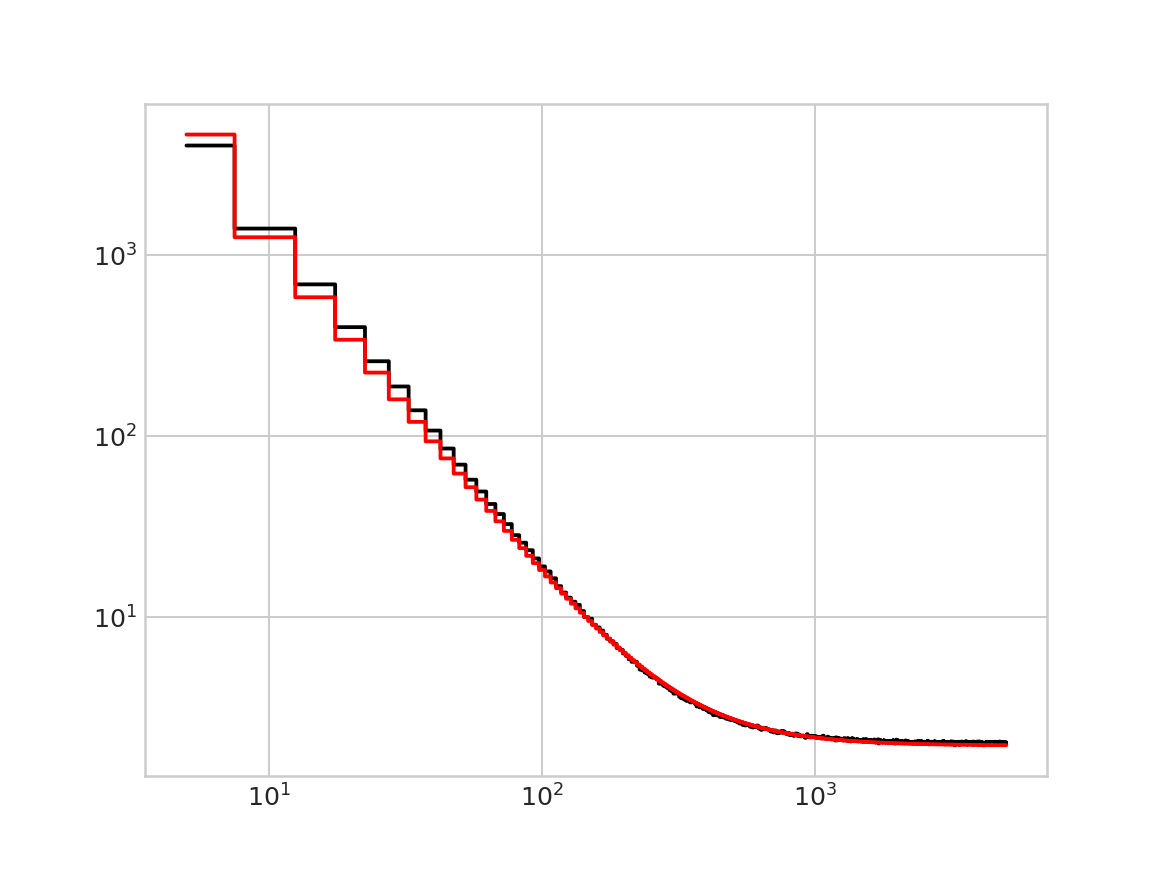

In [41]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

loglike = PSDLogLikelihood(avg_ps1.freq, avg_ps1.power, model=m, m=avg_ps1.m)
parest = PSDParEst(avg_ps1, max_post=False)
res = parest.fit(loglike, [1e4, 2, 2])

m.amplitude_0 = res.p_opt[0]
m.alpha_0 = res.p_opt[1]
m.amplitude_1 = res.p_opt[2]

mps = m(avg_ps1.freq)

plt.figure()
plt.loglog(avg_ps1.freq, avg_ps1.power, linestyle="steps-mid", color="black")
plt.loglog(avg_ps1.freq, mps, linestyle="steps-mid", color="red")

That looks about right. However, we want a red-noise model only for the cospectrum:

In [42]:
m_rn = models.PowerLaw1D()
m_rn.x_0.fixed=True


m_rn.amplitude = res.p_opt[0]
m_rn.alpha = res.p_opt[1]

mps_rn = m_rn(avg_ps1.freq)

In [43]:
true_pars = [26835.78651627, 1.93908191]

Now let's think about the cospectral powers. We're going to first calculate the product of the real and imaginary parts, and the square of the Fourier amplitudes for only light curve 1:

In [44]:
fourier_squared_real, fourier_squared_imag, fourier_squared_lc1 = [], [], []

for f1, f2 in zip(fourier1_all, fourier2_all):
    fourier_squared_real.append(f1.real * f2.real)
    fourier_squared_imag.append(f1.imag * f2.imag)
    fourier_squared_lc1.append(f1.conj() * f1)

Let's take a look what the distribution of these look like for different values of the underlying PSD:

In [45]:
len(mps_rn)

999

In [47]:
print(mps_rn[10])
print(mps_rn[100])
print(mps_rn[998])

50.205303267994076
0.7644441550354953
0.010114647020588096


In [48]:
fourier_squared_real = np.array(fourier_squared_real)
fourier_squared_imag = np.array(fourier_squared_imag)
fourier_squared_lc1 = np.array(fourier_squared_lc1)

In [50]:
freq_idx1 = 10
freq_idx2 = 100
freq_idx3 = 998

<IPython.core.display.Javascript object>


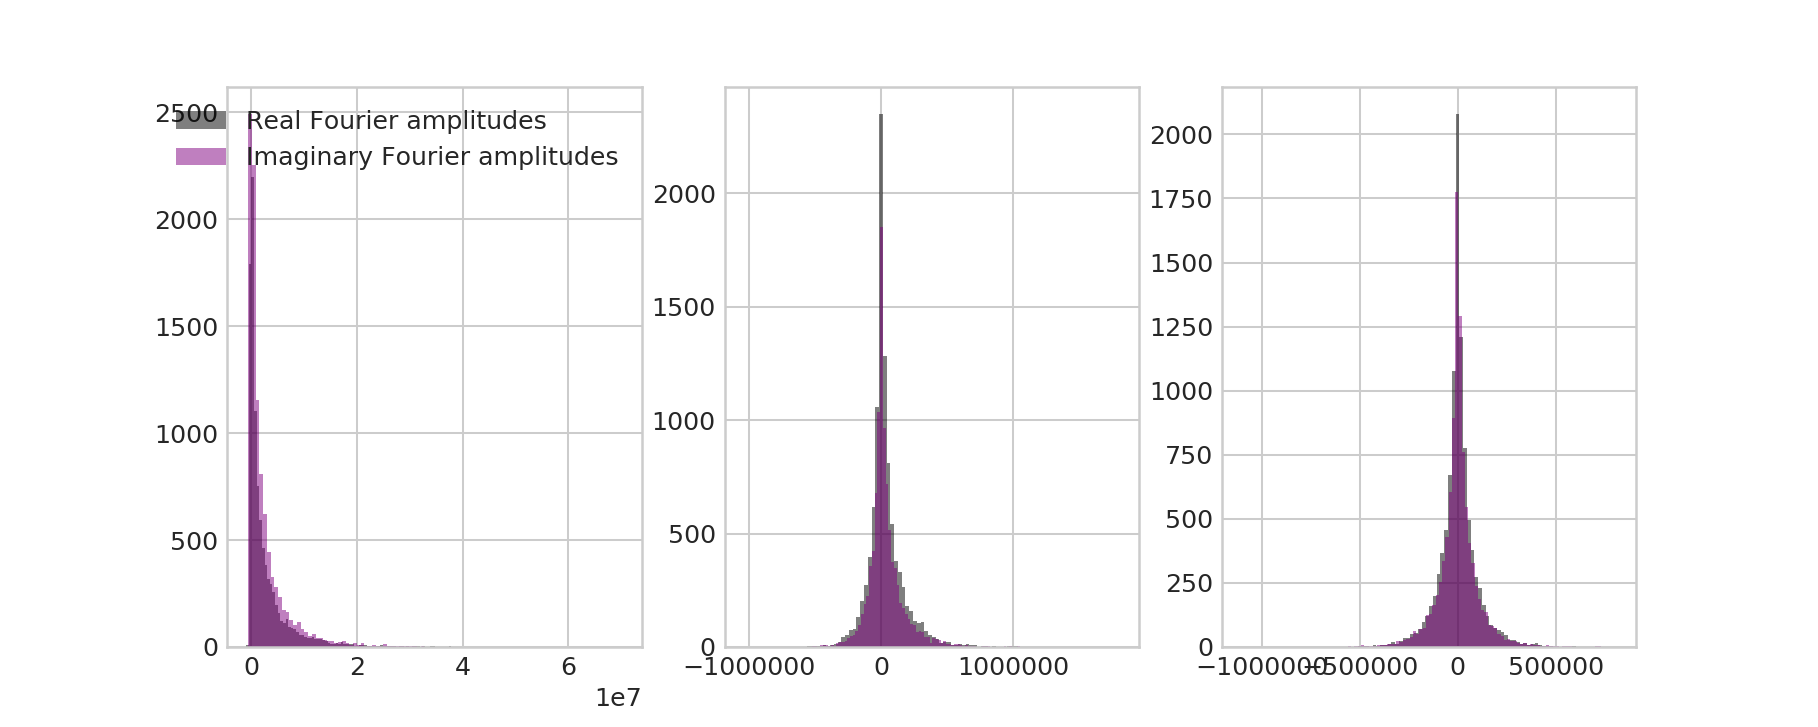

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(fourier_squared_real[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes")
ax1.hist(fourier_squared_imag[:,freq_idx1], bins=100, histtype="stepfilled", color="purple", 
         alpha=0.5, label="Imaginary Fourier amplitudes")
#ax1.hist(fourier_squared_lc1[:,freq_idx1], bins=100, histtype="stepfilled", color="orange", 
#         alpha=0.5, label="Squared Fourier Amplitudes, LC1")

ax1.legend()

ax2.hist(fourier_squared_real[:,freq_idx2], bins=100, histtype="stepfilled", color="black", alpha=0.5)
ax2.hist(fourier_squared_imag[:,freq_idx2], bins=100, histtype="stepfilled", color="purple", alpha=0.5)
#ax2.hist(fourier_squared_lc1[:,freq_idx2], bins=100, histtype="stepfilled", color="orange", alpha=0.5)

ax3.hist(fourier_squared_real[:,freq_idx3], bins=100, histtype="stepfilled", color="black", alpha=0.5);
ax3.hist(fourier_squared_imag[:,freq_idx3], bins=100, histtype="stepfilled", color="purple", alpha=0.5);
#ax3.hist(fourier_squared_lc1[:,freq_idx3], bins=100, histtype="stepfilled", color="orange", alpha=0.5);


Just a check: are the real and imaginary parts independent?

In [52]:
fourier_diff = fourier_squared_real - fourier_squared_imag

In [53]:
fourier_diff.shape

(10000, 999)

<IPython.core.display.Javascript object>


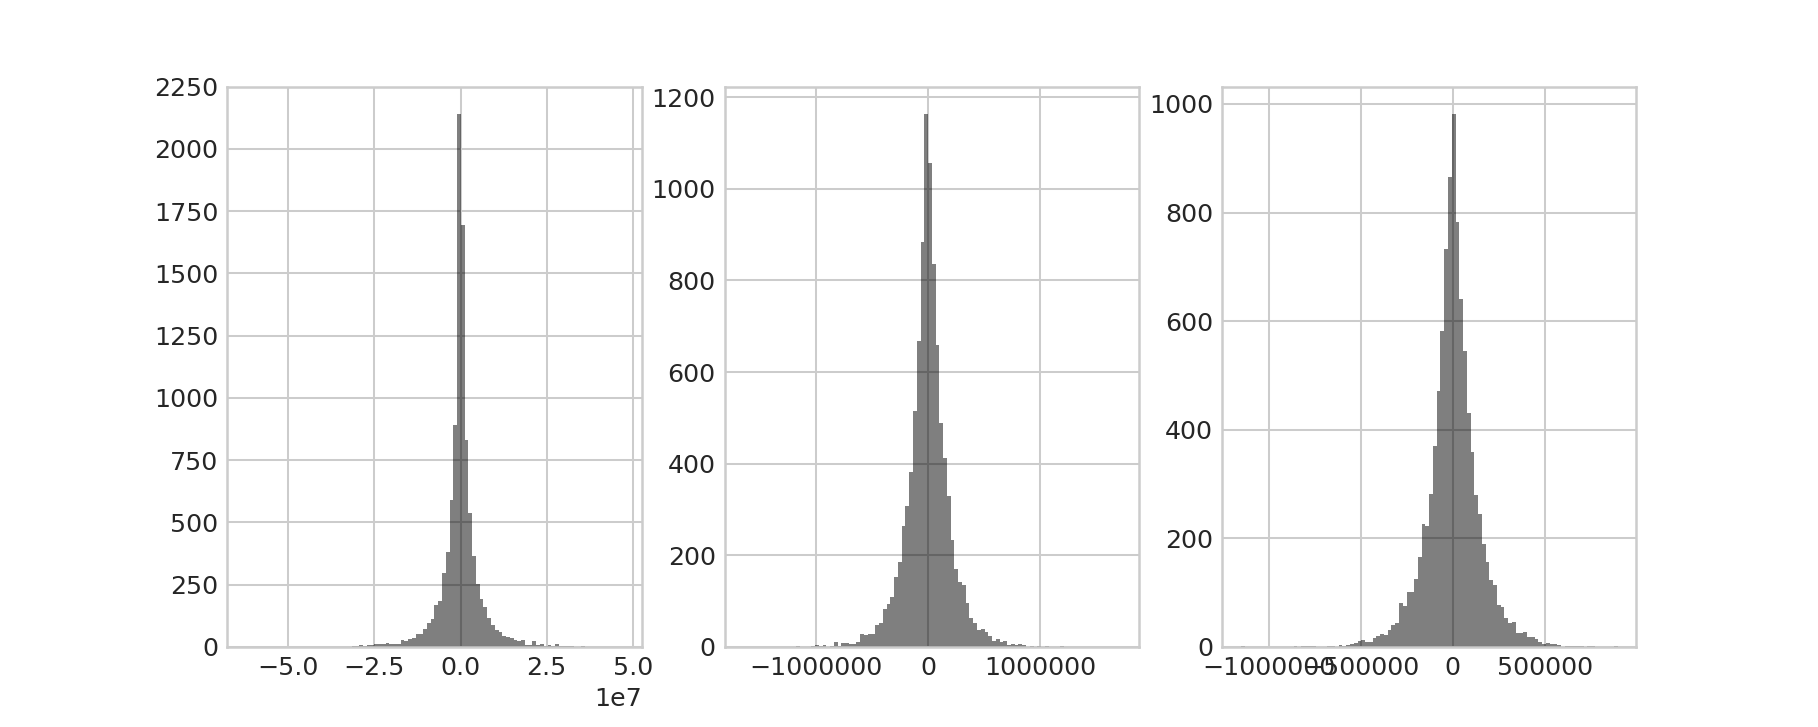

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(fourier_diff[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes")


ax2.hist(fourier_diff[:,freq_idx2], bins=100, histtype="stepfilled", color="black", alpha=0.5)

ax3.hist(fourier_diff[:,freq_idx3], bins=100, histtype="stepfilled", color="black", alpha=0.5);


<IPython.core.display.Javascript object>


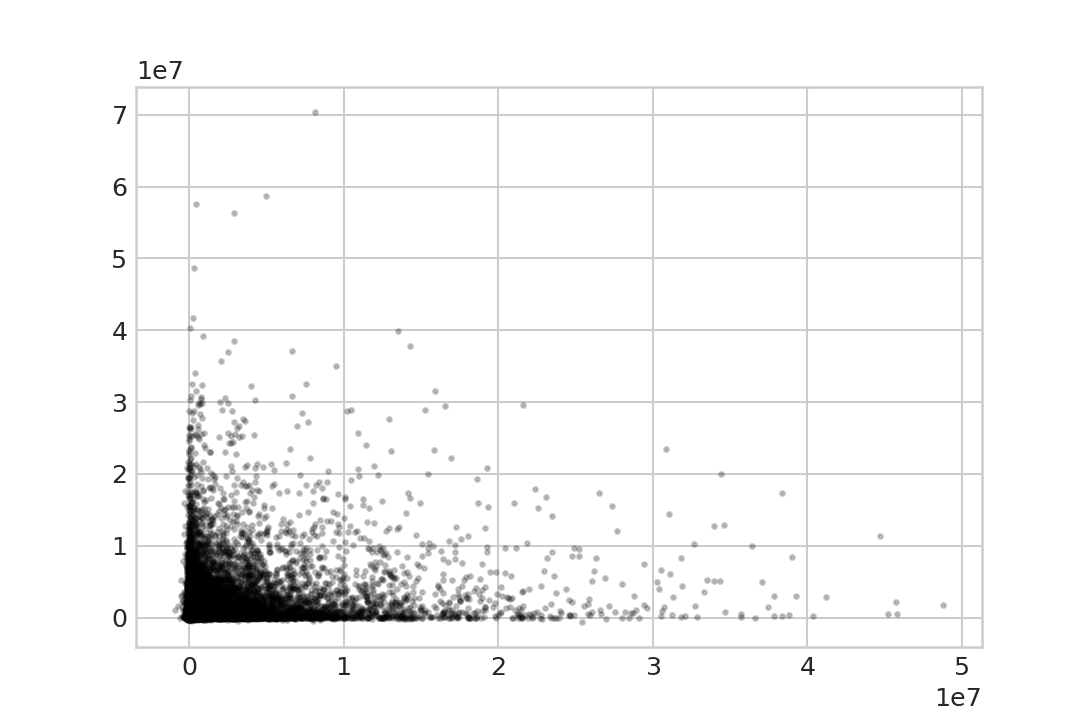

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.scatter(fourier_squared_real[:,freq_idx1], fourier_squared_imag[:,freq_idx1], s=3, c="black", alpha=0.2)

In [56]:
corrcoeff_all = []

for i in range(fourier_squared_real.shape[1]):
     corrcoeff_all.append(np.corrcoef(fourier_squared_real[:,i], fourier_squared_imag[:,i])[0,1])

<IPython.core.display.Javascript object>


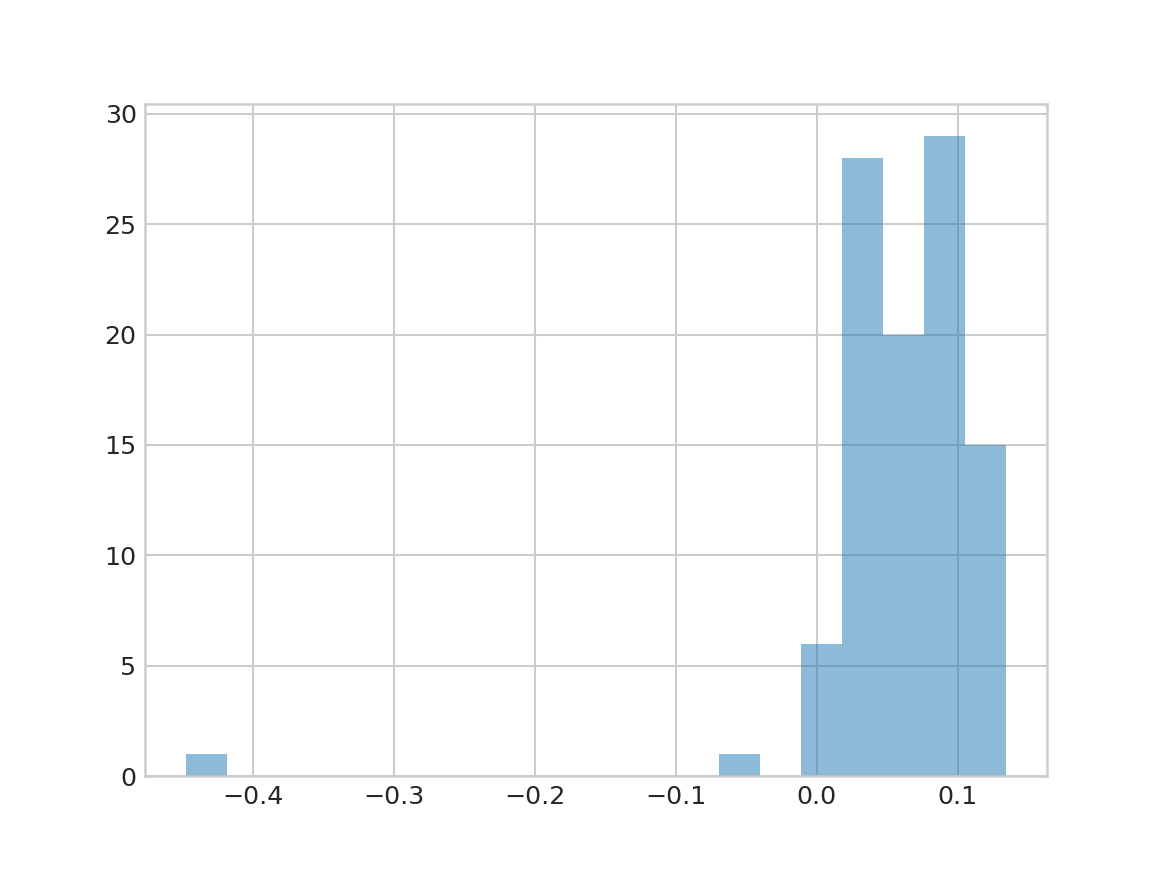

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  6., 28., 20., 29., 15.]),
 array([-0.44705792, -0.4179905 , -0.38892309, -0.35985568, -0.33078826,
        -0.30172085, -0.27265343, -0.24358602, -0.21451861, -0.18545119,
        -0.15638378, -0.12731636, -0.09824895, -0.06918154, -0.04011412,
        -0.01104671,  0.01802071,  0.04708812,  0.07615553,  0.10522295,
         0.13429036]),
 <a list of 1 Patch objects>)

In [57]:
plt.figure()

plt.hist(corrcoeff_all[:freq_idx2], bins=20, histtype="stepfilled", alpha=0.5)

Hmmm, so that looks like for red noise, the Fourier amplitudes for $X$ and $Y$ might not be independent? Why?

Ok, great. Now I want to calculate the theoretical expectations for the product of the Fourier amplitudes. For this, I need to know the *variances* and the *correlation coefficient* at a given frequency.

The correlation coefficient for my PSDs is defined as

$$
\rho_j = \frac{P_j}{P_j + 2}
$$

where $P_j = P(\nu_j)$ is the power at a given frequency $\nu_j$.


In [58]:
mcorr = mps_rn / (mps_rn + 2.)
mcorr_data = (avg_ps1.power-2.0) / (avg_ps1.power)

The variances are defined as:

$$
\sigma_X^2 = \sigma_s^2 + \sigma_n^2 = N_{\mathrm{phot}} \frac{P_j}{4} + \frac{N_{\mathrm{phot}}}{2} = \frac{N_{\mathrm{phot}}}{4} (P_j + 2) \; ,
$$

where $P_j$ is the power spectrum at frequency $\nu_j$, $\sigma_s^2$ is the variance of the signal, and $\sigma_n^2$ is the variance of the white noise component.

In [59]:
nphot = np.mean(lc1_counts_all)

In [60]:
mvar = nphot/4 * (mps_rn + 2.)
mvar_data = nphot/4 * (avg_ps1.power)

Now let's see if I can calculate the theoretical expectations for the product of Fourier amplitudes:

In [61]:
x10 = np.linspace(-1e7, 4e8, 10000)
x100 = np.linspace(-2.5e6, 7.5e6, 10000)
x1000 = np.linspace(-2e6, 3e6, 10000)

v = mvar_data

bessel_p_10 = bessel_probability(x10, np.sqrt(v[freq_idx1]), np.sqrt(v[freq_idx1]), mcorr_data[freq_idx1])
bessel_p_100 = bessel_probability(x100, np.sqrt(v[freq_idx2]), np.sqrt(v[freq_idx2]), mcorr_data[freq_idx2])
bessel_p_1000 = bessel_probability(x1000, np.sqrt(v[freq_idx3]), np.sqrt(v[freq_idx3]), mcorr_data[freq_idx3])


<IPython.core.display.Javascript object>


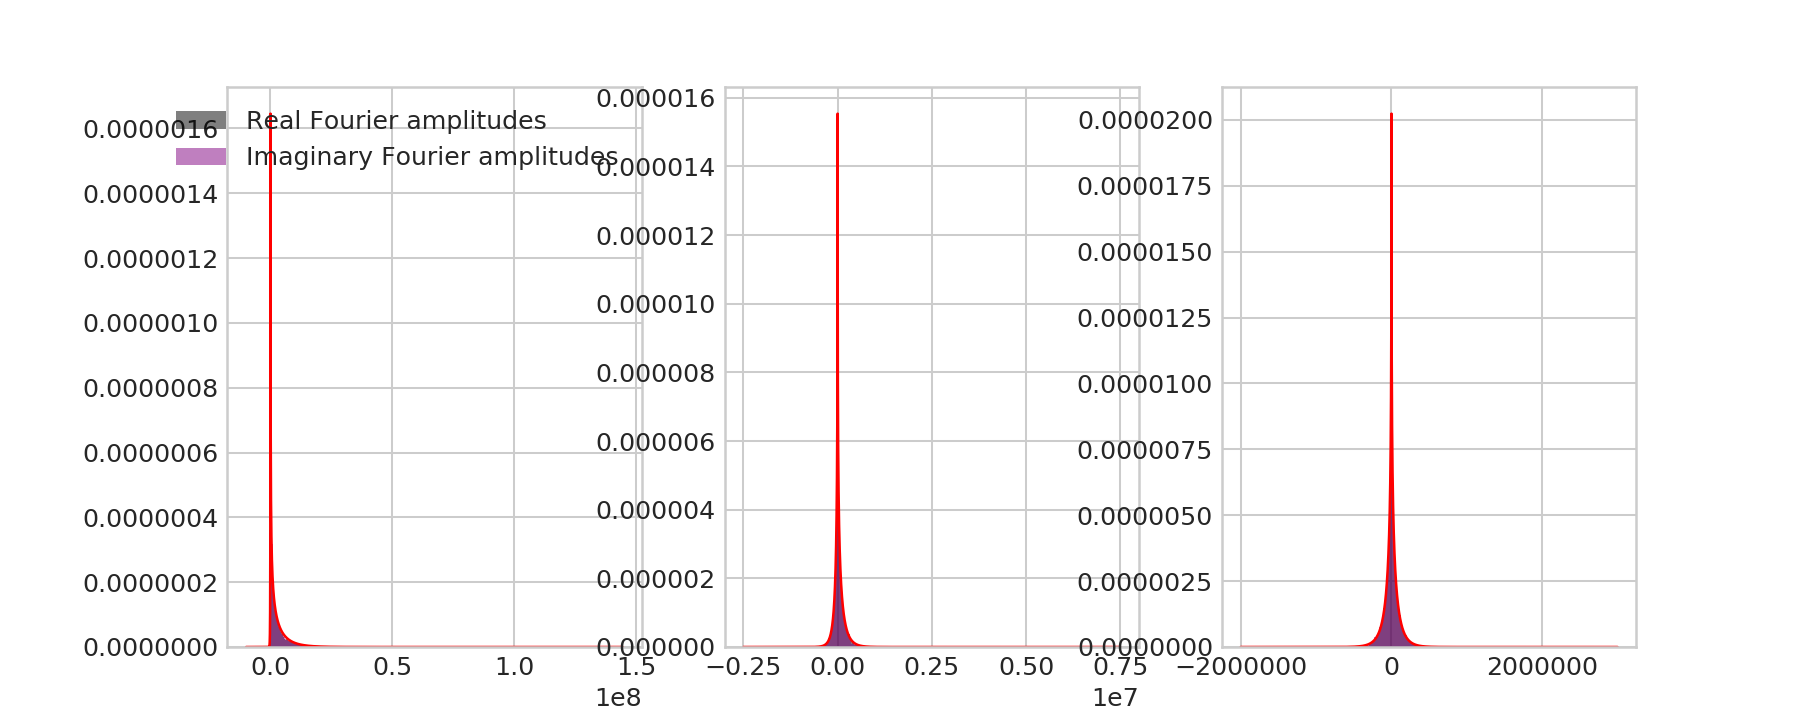

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(fourier_squared_real[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes", density=True)
ax1.hist(fourier_squared_imag[:,freq_idx1], bins=100, histtype="stepfilled", color="purple", 
         alpha=0.5, label="Imaginary Fourier amplitudes", density=True)
#ax1.hist(fourier_squared_lc1[:,freq_idx1], bins=100, histtype="stepfilled", color="orange", 
#         alpha=0.5, label="Squared Fourier Amplitudes, LC1", density=True)
ax1.plot(x10, bessel_p_10, lw=1, color="red")
ax1.legend()

ax2.hist(fourier_squared_real[:,freq_idx2], bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
ax2.hist(fourier_squared_imag[:,freq_idx2], bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True)
#ax2.hist(fourier_squared_lc1[:,freq_idx2], bins=100, histtype="stepfilled", color="orange", alpha=0.5, density=True)
ax2.plot(x100, bessel_p_100, lw=1, color="red")

ax3.hist(fourier_squared_real[:,freq_idx3], bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax3.hist(fourier_squared_imag[:,freq_idx3], bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True);
#ax3.hist(fourier_squared_lc1[:,freq_idx3], bins=100, histtype="stepfilled", color="orange", alpha=0.5, density=True);
ax3.plot(x1000, bessel_p_1000, lw=1, color="red")


Ok, that all looks pretty good!

What about the cospectral powers?

In [63]:
csd_normed_all = np.array(csd_normed_all)
csd_all = np.array(csd_all)

<IPython.core.display.Javascript object>


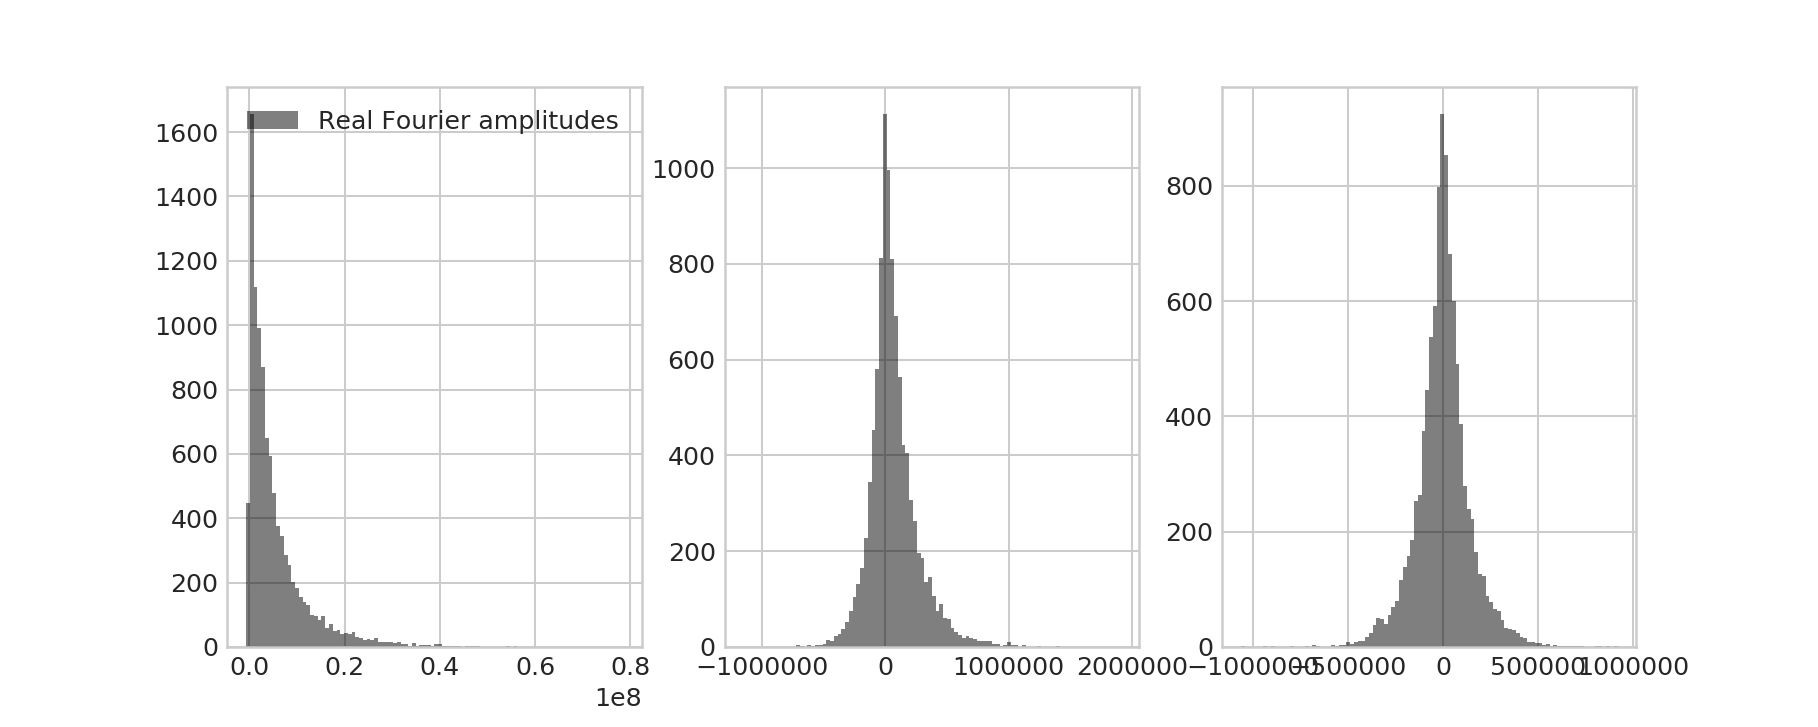

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(csd_all[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes")

ax1.legend()

ax2.hist(csd_all[:,freq_idx2], bins=100, histtype="stepfilled", color="black", alpha=0.5)

ax3.hist(csd_all[:,freq_idx3], bins=100, histtype="stepfilled", color="black", alpha=0.5);


Let's now calculate the cospectral probabilities for these:

In [65]:

x10 = np.linspace(-1e8, 2.5e8, 10000)
x100 = np.linspace(-5e6, 4e6, 10000)
x1000 = np.linspace(-1.5e6, 1.5e6, 10000)

v = 2*mvar_data

csd_p_10 = mean_corr_prob(x10, np.sqrt(v[freq_idx1]), np.sqrt(v[freq_idx1]), mcorr_data[freq_idx1])
csd_p_100 = mean_corr_prob(x100, np.sqrt(v[freq_idx2]), np.sqrt(v[freq_idx2]), mcorr_data[freq_idx2])
csd_p_1000 = mean_corr_prob(x1000, np.sqrt(v[freq_idx3]), np.sqrt(v[freq_idx3]), mcorr_data[freq_idx3])


<IPython.core.display.Javascript object>


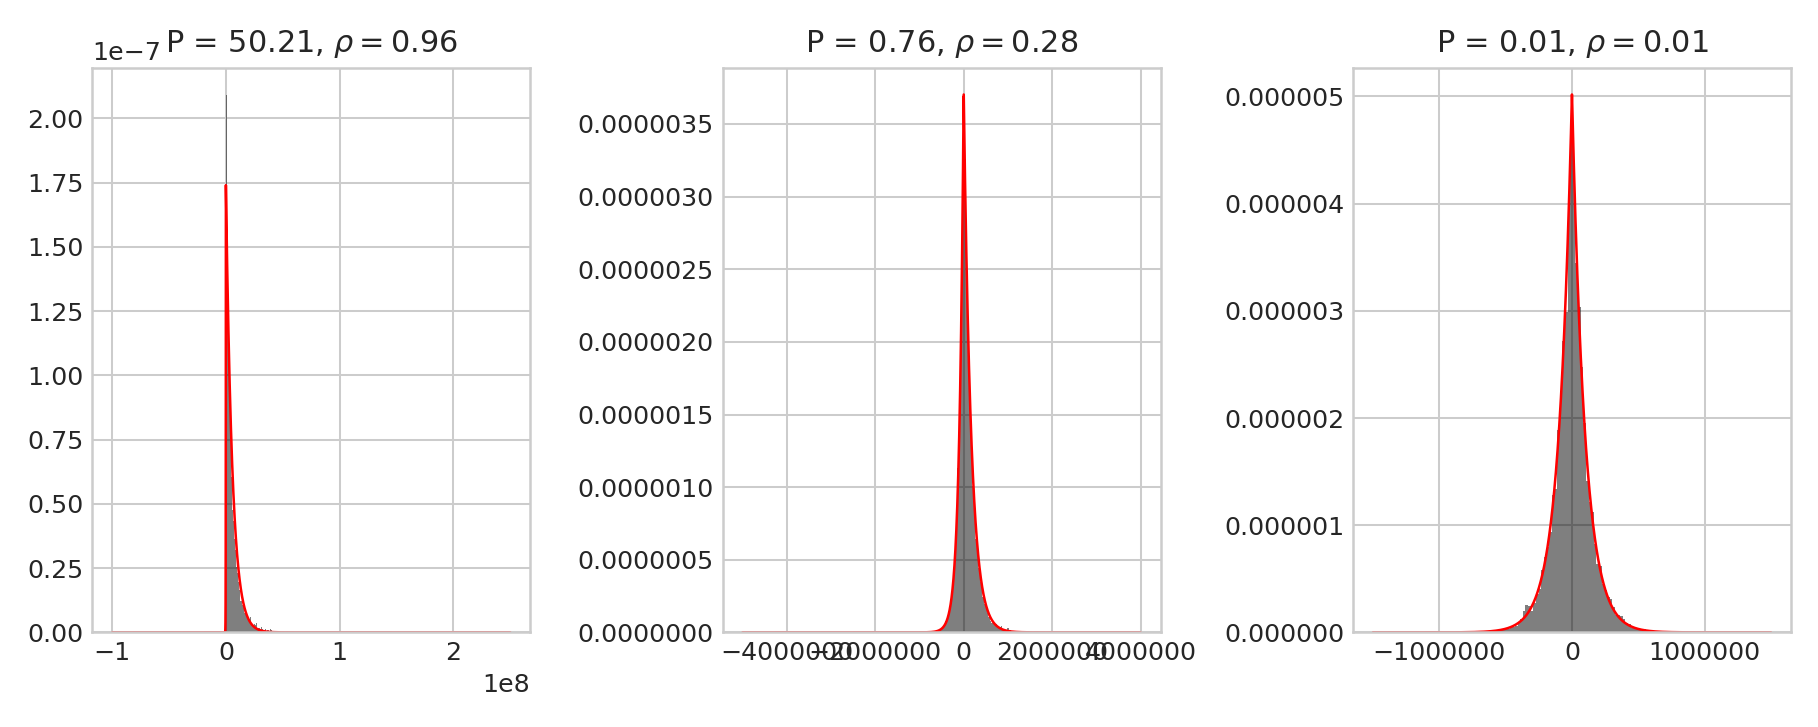

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(csd_all[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes", density=True)
ax1.plot(x10, csd_p_10, color="red", lw=1)
ax1.set_title(r"P = %.2f, $\rho=%.2f$"%(mps_rn[freq_idx1], mcorr[freq_idx1]))
#ax1.legend()

ax2.hist(csd_all[:,freq_idx2], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, density=True)


ax2.plot(x100, csd_p_100, color="red", lw=1)
ax2.set_title(r"P = %.2f, $\rho=%.2f$"%(mps_rn[freq_idx2], mcorr[freq_idx2]))

ax3.hist(csd_all[:,freq_idx3], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, density=True);
ax3.plot(x1000, csd_p_1000, color="red", lw=1)
ax3.set_title(r"P = %.2f, $\rho=%.2f$"%(mps_rn[freq_idx3], mcorr[freq_idx3]))

plt.tight_layout()

Okay, that seems to broadly work, except for the cases where the numbers get really large. 

But these are the unnormalized powers, so I suspect there's something going on with the normalization. The power spectrum I fit was fit to a **Leahy-normalized** averaged PSD. 

What if the variance ought to be

$$
\sigma_X = P_j +2 
$$

i.e. just the power spectrum with the noise included? Let's try that:

In [67]:
mvar_normed = mps_rn + 2.0
mvar_normed_data = avg_ps1.power

In [303]:
x10 = np.linspace(-100, 1000, 1000)
x100 = np.linspace(-10, 30, 1000)
x1000 = np.linspace(-7, 7, 1000)

csd_p_10 = mean_corr_prob(x10, np.sqrt(mvar_normed_data[freq_idx1]), np.sqrt(mvar_normed_data[freq_idx1]), mcorr_data[freq_idx1])
csd_p_100 = mean_corr_prob(x100, np.sqrt(mvar_normed_data[freq_idx2]), np.sqrt(mvar_normed_data[freq_idx2]), mcorr_data[freq_idx2])
csd_p_1000 = mean_corr_prob(x1000, np.sqrt(mvar_normed_data[freq_idx3]), np.sqrt(mvar_normed_data[freq_idx3]), mcorr_data[freq_idx3])


<IPython.core.display.Javascript object>


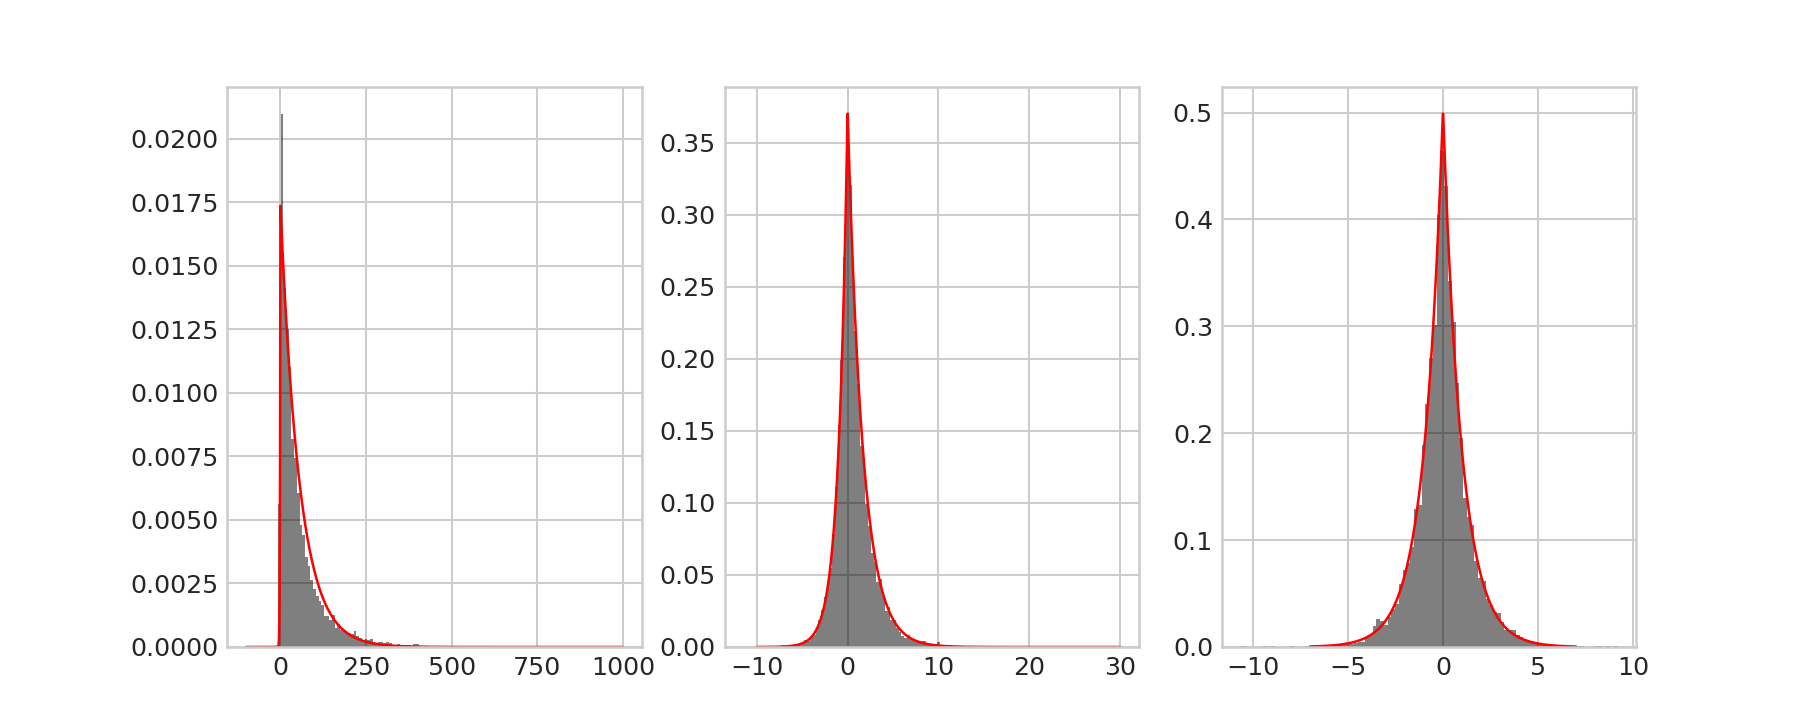

In [304]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(csd_normed_all[:,freq_idx1], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes", density=True)
ax1.plot(x10, csd_p_10, color="red", lw=1)

ax2.hist(csd_normed_all[:,freq_idx2], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, density=True)
ax2.plot(x100, csd_p_100, color="red", lw=1)

ax3.hist(csd_normed_all[:,freq_idx3], bins=100, histtype="stepfilled", color="black", 
         alpha=0.5, density=True);
ax3.plot(x1000, csd_p_1000, color="red", lw=1)


How good are those estimates? What I really should do is some tests like I did for the product distribution above, and then compare this to the data via the KL-divergence.

## Simulating the sums

Let's try to simulate the sums the same way we simulated the products above:

<IPython.core.display.Javascript object>


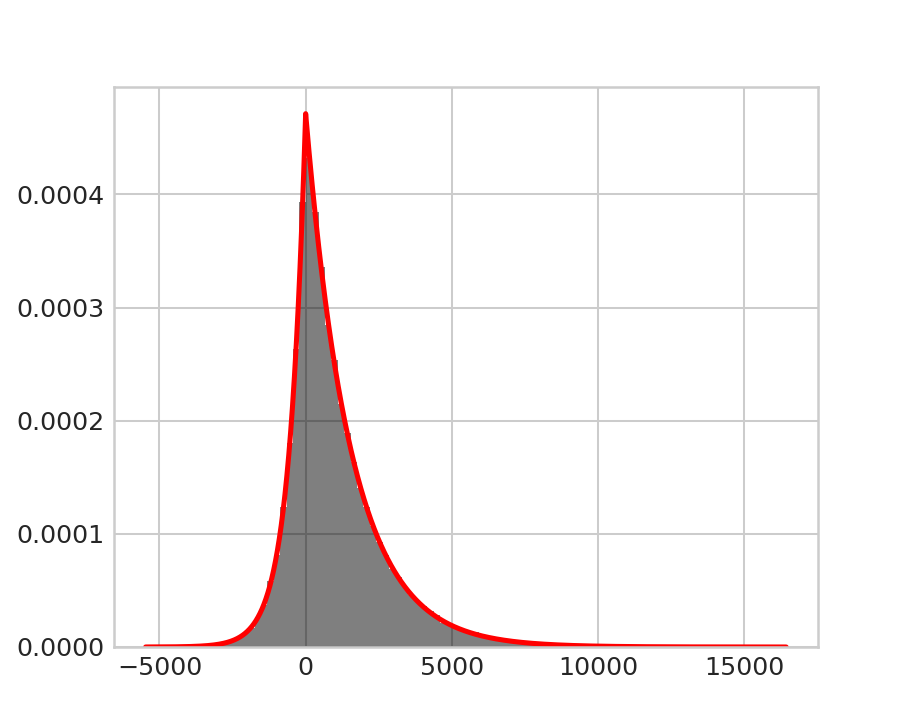

In [368]:
rmeans = [0,0]
rvar1 = 1500
rvar2 = 3000
rcov = 1000

rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=100000)
rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=100000)

rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

rmean = (rmult1 + rmult2)/2.

corr = corrcoeff1[0,1]

x = np.linspace(np.min(rmean), np.max(rmean), 100000)
m_prob = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(rmean, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True);
ax.plot(x, m_prob, lw=2, color="red")

In [366]:
rvar1

1500

In [369]:
rvar2

3000

Can we write a function to numerically integrate the PDF so we get an estimate for the CDF? Then we could do a KS-test:

In [370]:
def mean_corr_cdf(x, rvar1, rvar2, corr, n=2, nsteps=1e6):
    
    mean_corr_var = rvar1 * rvar2 * (1. - corr**2.) + 2. * (corr**2.) * rvar1 * rvar2
    
    min_x = -5*mean_corr_var
    
    xt = np.linspace(min_x, x, num=nsteps)
    p = mean_corr_prob(xt, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)
    
    cdf = np.sum(p*(xt[1]-xt[0]))
    
    return cdf

Let's try it. We're also going to make a histogram of our samples to compare:

In [373]:
hist, bin_edges = np.histogram(rmean, bins=1000, density=True, normed=True);

In [374]:
emp_cdf = np.cumsum(hist*(bin_edges[1] - bin_edges[0]))

In [375]:
len(emp_cdf)

1000

In [376]:
len(bin_edges)

1001

Now let's calculate the numerical version on a very fine grid:

In [377]:
mean_corr_var = rvar1 * rvar2 * (1. - corr**2.) + 2. * (corr**2.) * rvar1 * rvar2
print("Variance of the distribution: " + str(mean_corr_var))

x = np.linspace(np.min(rmean), np.max(rmean), 1e6)

Variance of the distribution: 5482552.890421791


In [378]:
num_pdf = mean_corr_prob(x, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

In [379]:
num_cdf = np.cumsum(num_pdf * (x[1] - x[0]))

In [380]:
%timeit mean_corr_cdf(i, rvar1, rvar2, corr, n=2, nsteps=1e4)

1.91 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
x2 = np.linspace(-2000, 8000, 10)
num_cdf2 = np.array([mean_corr_cdf(i, rvar1, rvar2, corr, n=2, nsteps=1e6) for i in x2])

<IPython.core.display.Javascript object>


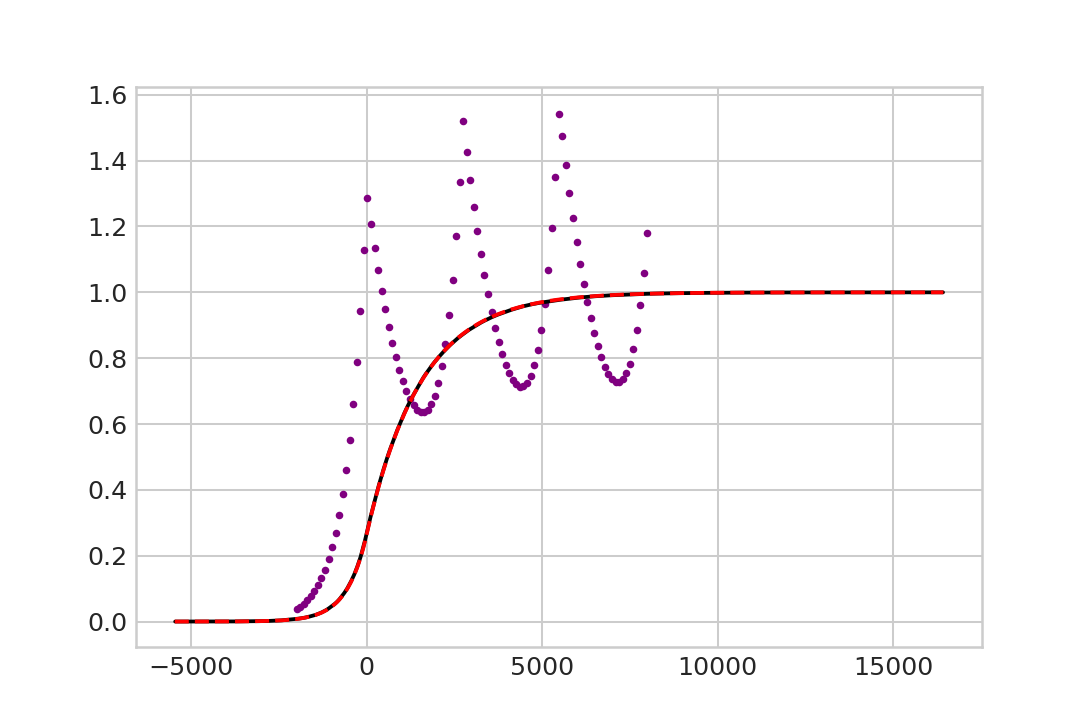

In [388]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(bin_edges[:-1] + np.diff(bin_edges)/2., emp_cdf, color="black")
ax.plot(x, num_cdf, color="red", linestyle="dashed")
ax.scatter(x2, num_cdf2, s=4, c="purple")

Ok, cool, that works. Now we want to do the same with the real data:

<IPython.core.display.Javascript object>


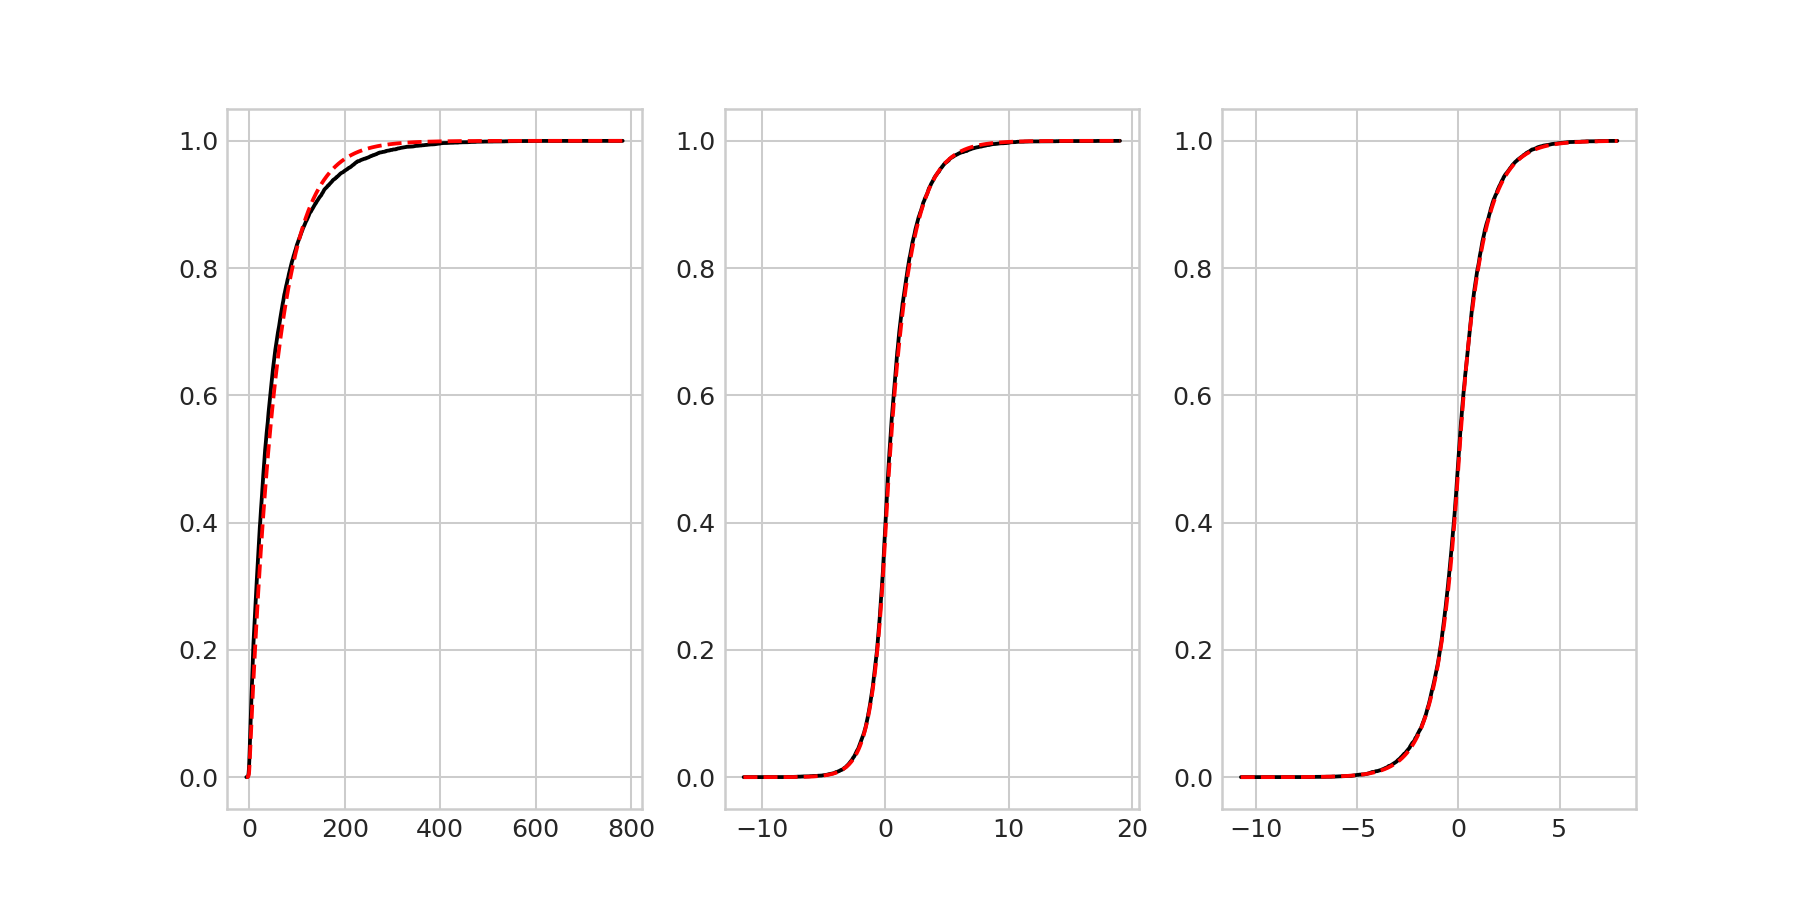

In [359]:
idx1 = 10
idx2 = 100
idx3 = 499

nbins = 1000
nsteps = 1e6

fig, axes = plt.subplots(1, 3, figsize=(10,5))

for j,i in enumerate([idx1, idx2, idx3]):
    
    csd_hist, bin_edges = np.histogram(csd_normed_all[:,i], bins=nbins, density=True, normed=True)
    c_pdf = np.cumsum(csd_hist * (bin_edges[1] - bin_edges[0]))
    
    x = np.linspace(bin_edges[0], bin_edges[-1], 1e6)
    m_prob = mean_corr_prob(x, np.sqrt(mvar_normed_data[i]), 
                          np.sqrt(mvar_normed_data[i]), mcorr_data[i])
    m_cdf = np.cumsum(m_prob * (x[1] - x[0]))
    
    axes[j].plot(bin_edges[:-1] + np.diff(bin_edges)/2., c_pdf, color="black")
    axes[j].plot(x, m_cdf, color="red", linestyle="dashed")


But can I calculate the Kullback-Leibler divergence?

In [245]:
hmean, bin_edges = np.histogram(rmean, bins=1000, density=True, normed=True)

In [246]:
bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.
m_prob = mean_corr_prob(bin_mid, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)

<IPython.core.display.Javascript object>


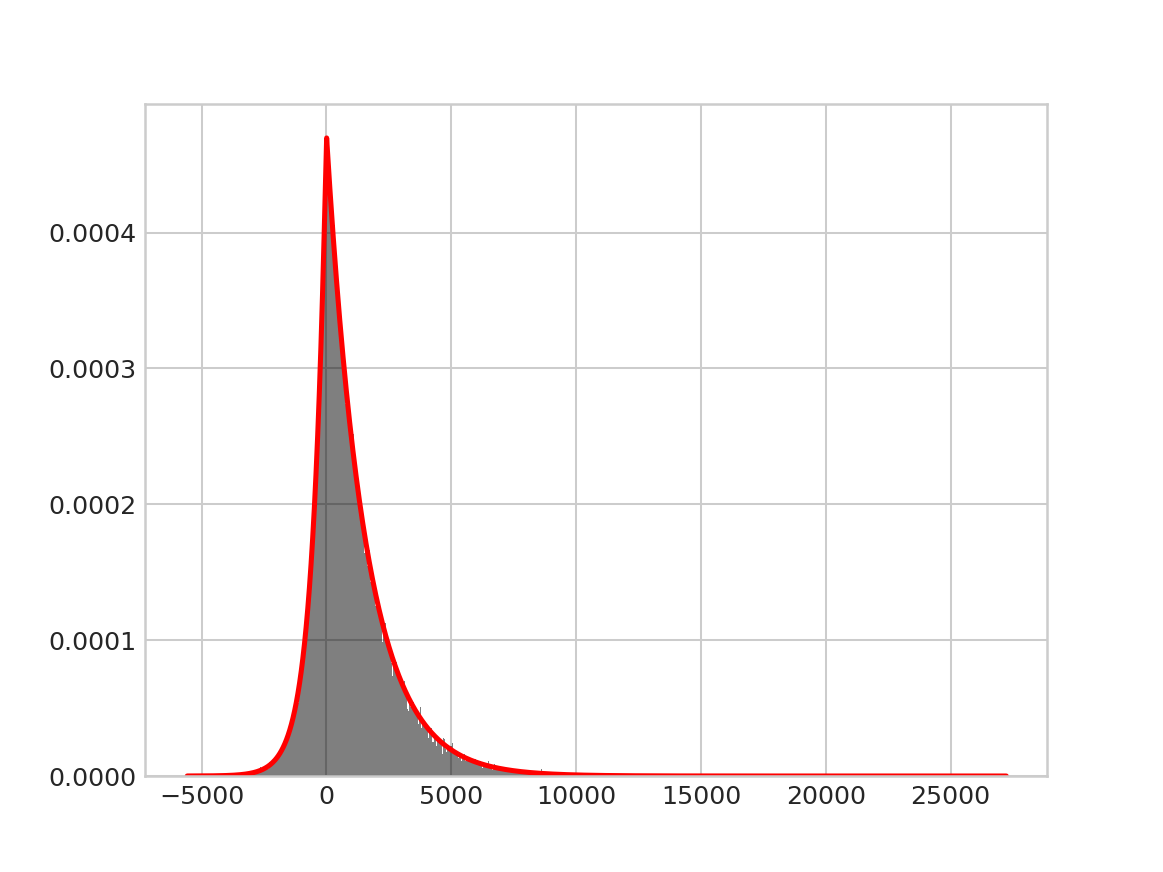

In [247]:
plt.figure()
plt.bar(bin_edges[:-1], hmean, width=np.diff(bin_edges), color="black", alpha=0.5);
plt.plot(bin_mid, m_prob, lw=2, color="red")

Okay, now let's see if we can calculate the KL-divergence:

In [180]:
kl_div = scipy.stats.entropy(hmean, m_prob)
print("The Kullback-Leibler divergence for this case is:  " + str(kl_div))

The Kullback-Leibler divergence for this case is:  0.04101527189477282


Can we do this for many data sets in order to get some kind of distribution of KL-divergences for noise data only?

In [844]:
rvar1 = np.sqrt(mvar_normed_data[20])
rvar2 = np.sqrt(mvar_normed_data[20])

rcov =  mcorr_data[20]
print("rvar1: " + str(rvar1))
print('rcov: ' + str(rcov))

rvar1: 4.226275304271837
rcov: 0.8880267129139396


In [845]:
ntests = 30000
nbins = 500

kl_div_sims = np.zeros(ntests)
tvs_sims = np.zeros(ntests)

for i in range(ntests):
    rsim1 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=20000)
    rsim2 = np.random.multivariate_normal(rmeans, [[rvar1, rcov], [rcov, rvar2]], size=20000)

    rmult1 = rsim1[:,0] * rsim1[:,1]
    rmult2 = rsim2[:,0] * rsim2[:,1]

    rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
    rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
    corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
    corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

    rmean = (rmult1 + rmult2)/2.

    corr = corrcoeff1[0,1]
    hmean, bin_edges = np.histogram(rmean, bins=nbins, density=True, normed=True)

    
    bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.
    m_prob = mean_corr_prob(bin_mid, np.sqrt(rvar1), np.sqrt(rvar2), corr, n=2)
    kl_div = scipy.stats.entropy(hmean, m_prob)
    
    tvs = np.sum(np.abs(hmean*np.diff(bin_edges) - m_prob*np.diff(bin_edges)))/2.
    tvs_sims[i] = tvs
    
    kl_div_sims[i] = kl_div

<IPython.core.display.Javascript object>


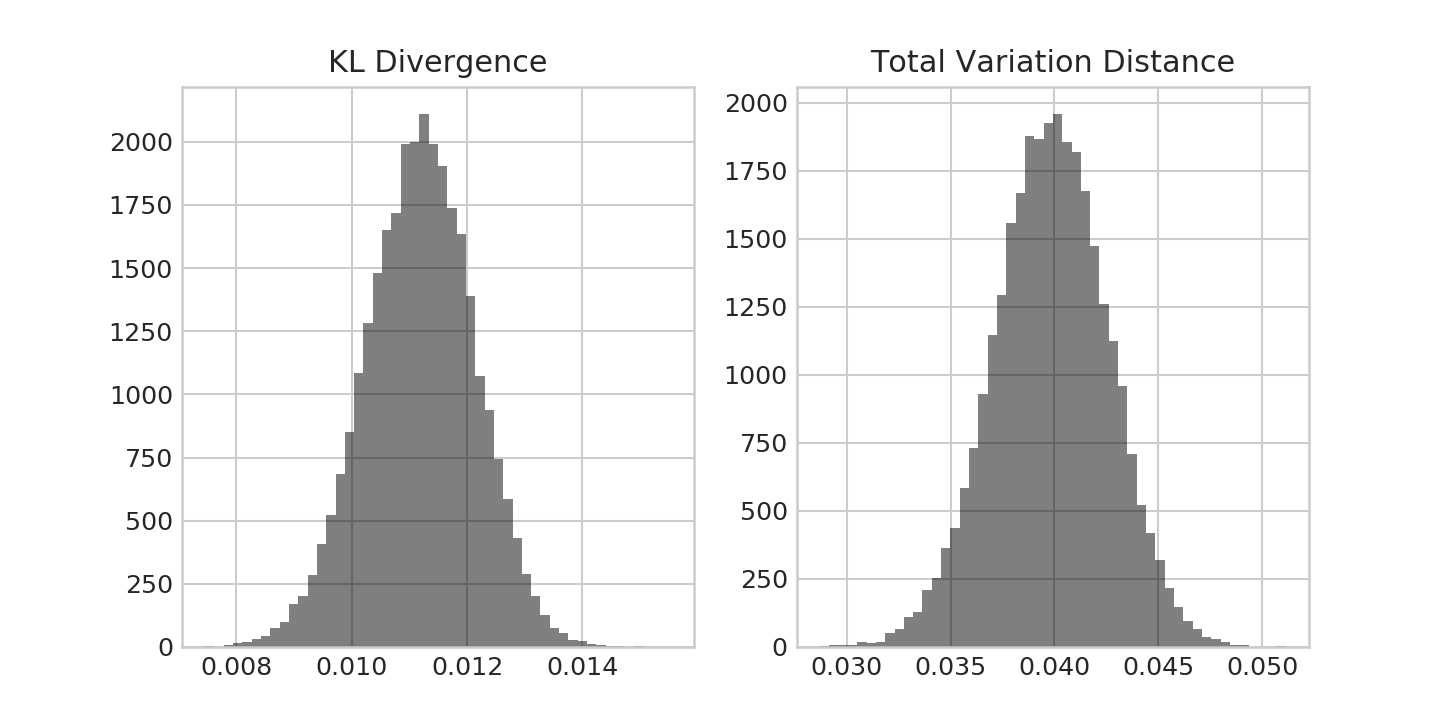

Text(0.5,1,'Total Variation Distance')

In [846]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(kl_div_sims, bins=50, histtype="stepfilled", alpha=0.5, color="black");
ax1.set_title("KL Divergence")

ax2.hist(tvs_sims, bins=50, histtype="stepfilled", alpha=0.5, color="black");
ax2.set_title("Total Variation Distance")


Now how about we try this for real data?

In [713]:
freq_loaded = np.loadtxt("../code/test_pl_nodeadtime_freq.dat")

In [714]:
cs_loaded = np.loadtxt("../code/test_pl_nodeadtime_cs.dat")

In [810]:
nbins

500

In [853]:
cs_loaded.shape

(20000, 999)

In [847]:
kl_csd, kl_loaded = np.zeros(csd_normed_all.shape[1]), np.zeros(csd_normed_all.shape[1])
tvs_csd, tvs_loaded = np.zeros(csd_normed_all.shape[1]), np.zeros(csd_normed_all.shape[1])

for i in range(cs_loaded.shape[1]):

    #histrange = [np.min(cs_loaded[:,i]), np.max(csd_normed_all[:,i])]
    csd_hist, bin_edges = np.histogram(cs_loaded[:,i], bins=nbins,
                                       density=True, normed=True)

    bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.

    m_prob = mean_corr_prob(bin_mid, np.sqrt(mvar_normed_data[i]), 
                          np.sqrt(mvar_normed_data[i]), mcorr_data[i])

    tvs = np.sum(np.abs(csd_hist*np.diff(bin_edges) - m_prob*np.diff(bin_edges)))/2.
    tvs_csd[i] = tvs

    kl_div = scipy.stats.entropy(csd_hist, m_prob)
    kl_csd[i] = kl_div


In [848]:
cs_loaded.shape

(20000, 999)

<IPython.core.display.Javascript object>


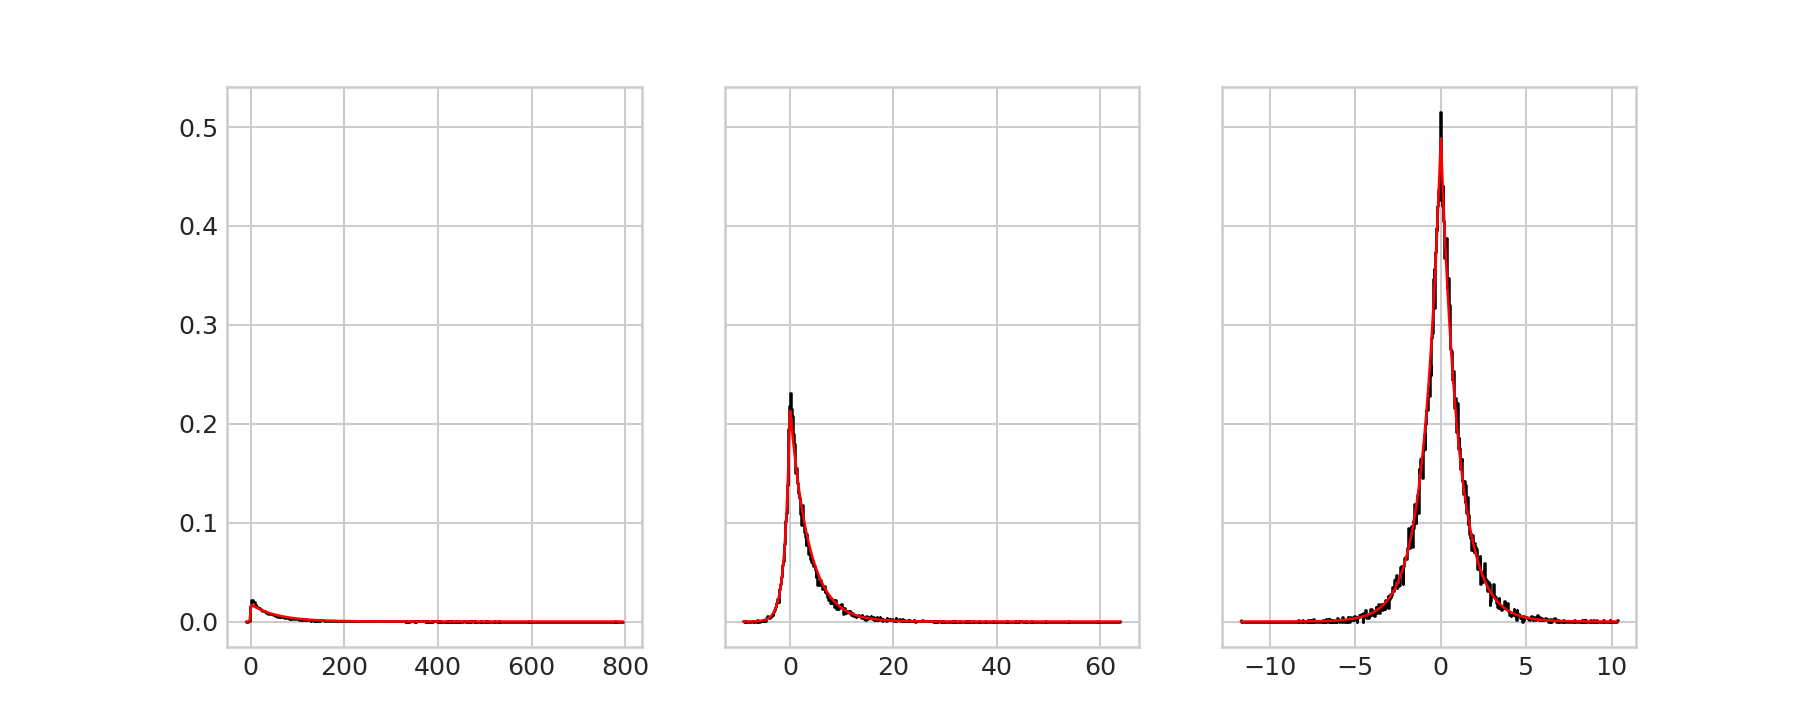

probability integral: 0.9999999999999996
probability integral: 1.0000000000000062
probability integral: 0.999999999999991


In [849]:
idx_all = [10, 50, 400]

fig, axes = plt.subplots(1, 3, figsize=(10,4), sharey=True)

axes = np.hstack(axes)

for i,idx in enumerate(idx_all):
    csd_hist, bin_edges = np.histogram(cs_loaded[:,idx], bins=nbins, density=True, normed=True)
    bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.
    
    print("probability integral: " + str(np.sum(csd_hist * (np.diff(bin_edges)[0]))))

    m_prob = mean_corr_prob(bin_mid, np.sqrt(mvar_normed_data[idx]), 
                          np.sqrt(mvar_normed_data[idx]), mcorr_data[idx])
    
    axes[i].plot(bin_mid, csd_hist, lw=1, color="black", linestyle="steps-mid")
    axes[i].plot(bin_mid, m_prob, lw=1, color="red")

Let's plot the difference between the two:

<IPython.core.display.Javascript object>


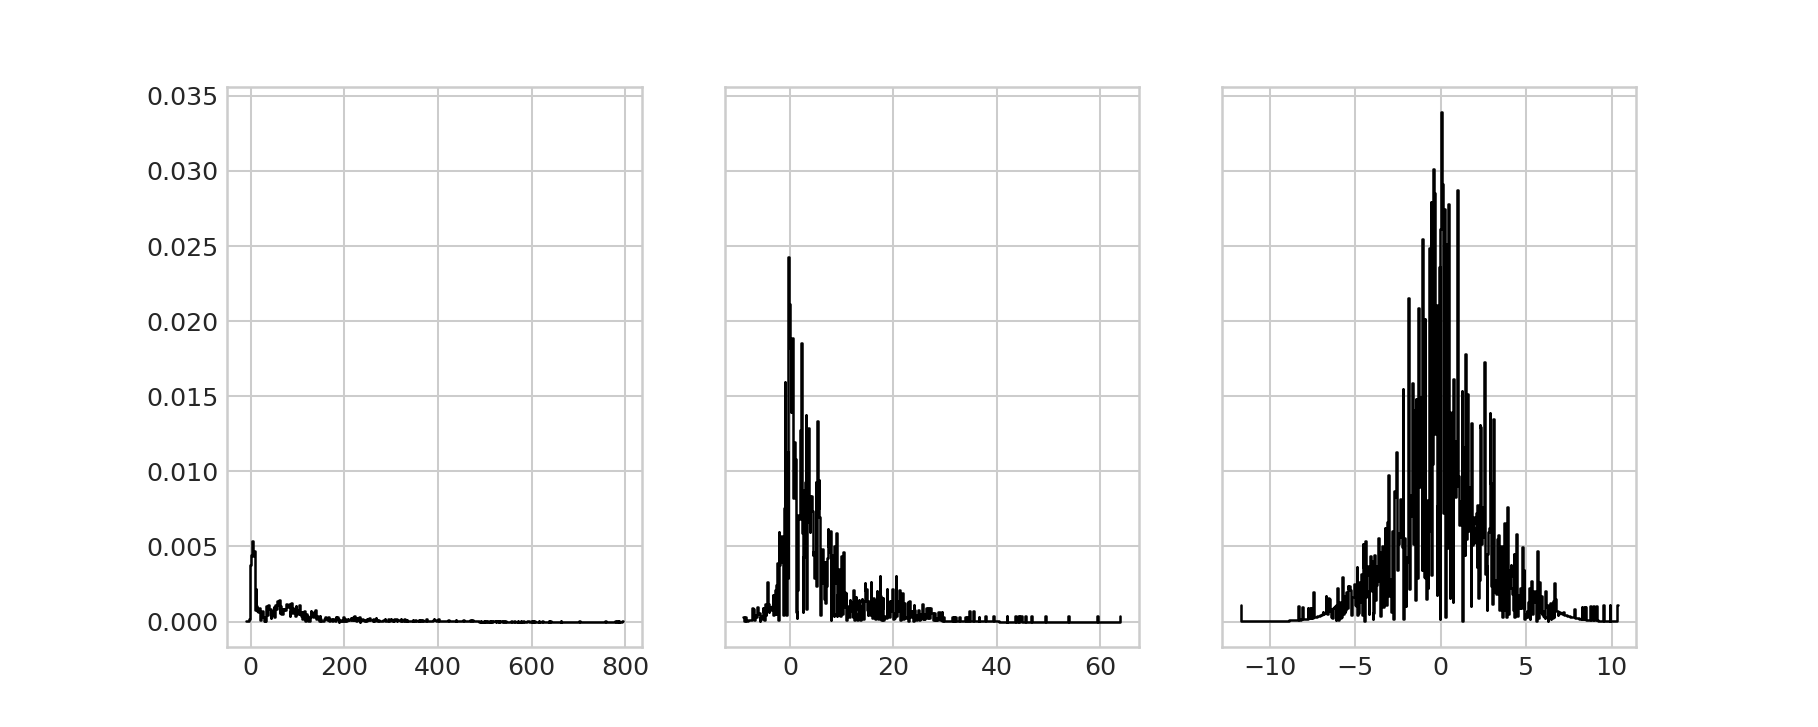

In [850]:
idx_all = [10, 50, 400]

fig, axes = plt.subplots(1, 3, figsize=(10,4), sharey=True)

axes = np.hstack(axes)

for i,idx in enumerate(idx_all):
    csd_hist, bin_edges = np.histogram(cs_loaded[:,idx], bins=nbins, density=True, normed=True)
    bin_mid = bin_edges[:-1] + np.diff(bin_edges)/2.

    m_prob = mean_corr_prob(bin_mid, np.sqrt(mvar_normed_data[idx]), 
                          np.sqrt(mvar_normed_data[idx]), mcorr_data[idx])
    
    axes[i].plot(bin_mid, np.abs(csd_hist-m_prob), lw=1, color="black", linestyle="steps-mid")
    #axes[i].plot(bin_mid, m_prob, lw=1, color="red")

What does this look like as a function of frequency?

<IPython.core.display.Javascript object>


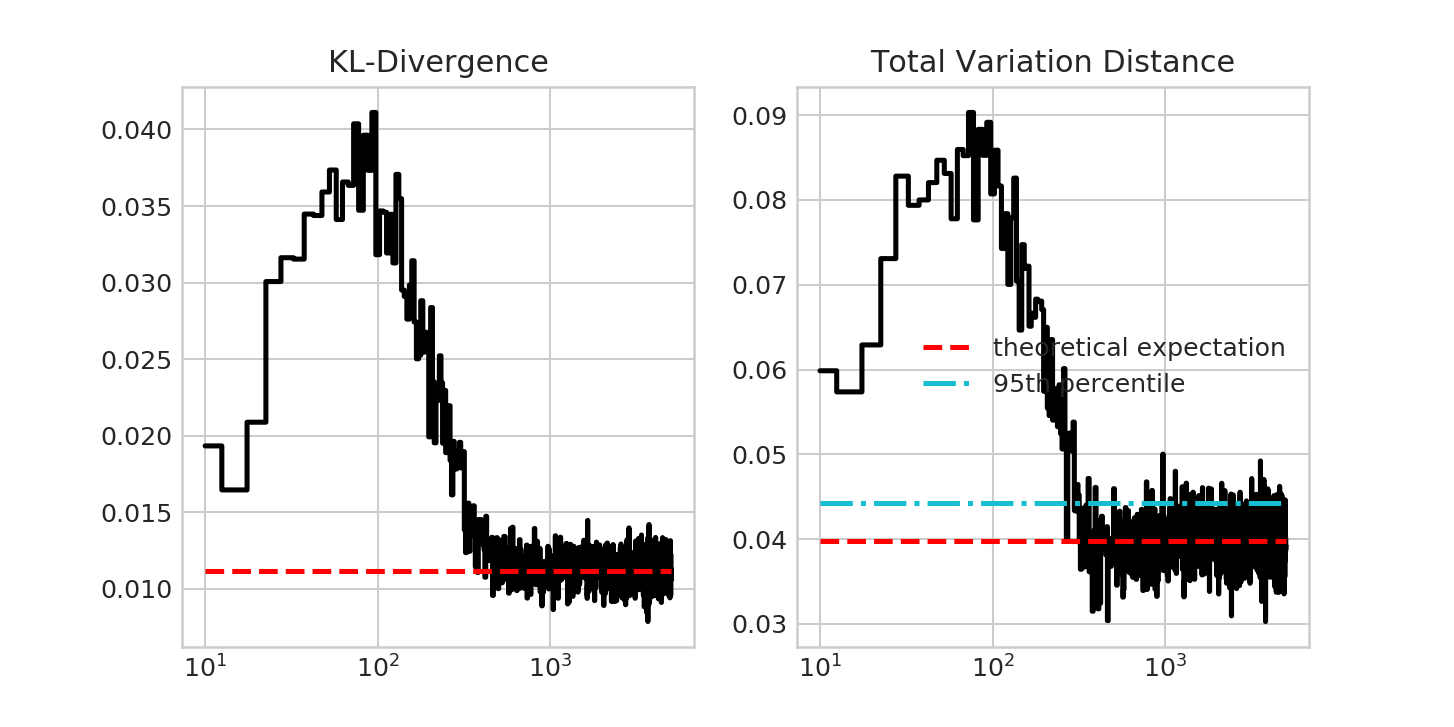

In [851]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.semilogx(ps1_all[0].freq[1:], kl_csd[1:], lw=2, color="black", linestyle="steps-mid")
ax1.set_title("KL-Divergence")
ax1.hlines(np.mean(kl_div_sims), ps1_all[0].freq[1], ps1_all[0].freq[-1], lw=2, 
           color="red", linestyle="dashed", zorder=10)

ax2.semilogx(ps1_all[0].freq[1:], tvs_csd[1:], lw=2, color="black", linestyle="steps-mid")
ax2.set_title("Total Variation Distance")
ax2.hlines(np.mean(tvs_sims), ps1_all[0].freq[1], ps1_all[0].freq[-1], lw=2, color="red", 
           linestyle="dashed", zorder=10, label="theoretical expectation")

ax2.hlines(np.percentile(tvs_sims, 95),  ps1_all[0].freq[1], ps1_all[0].freq[-1], lw=2,
           color=sns.color_palette()[9], linestyle="-.", zorder=10, label="95th percentile")

ax2.legend()

In [829]:
p_tvs = np.zeros_like(tvs_csd)

for i,t in enumerate(tvs_csd):
    p_tvs[i] = np.sum((tvs_sims >= t))/len(tvs_sims)

<IPython.core.display.Javascript object>


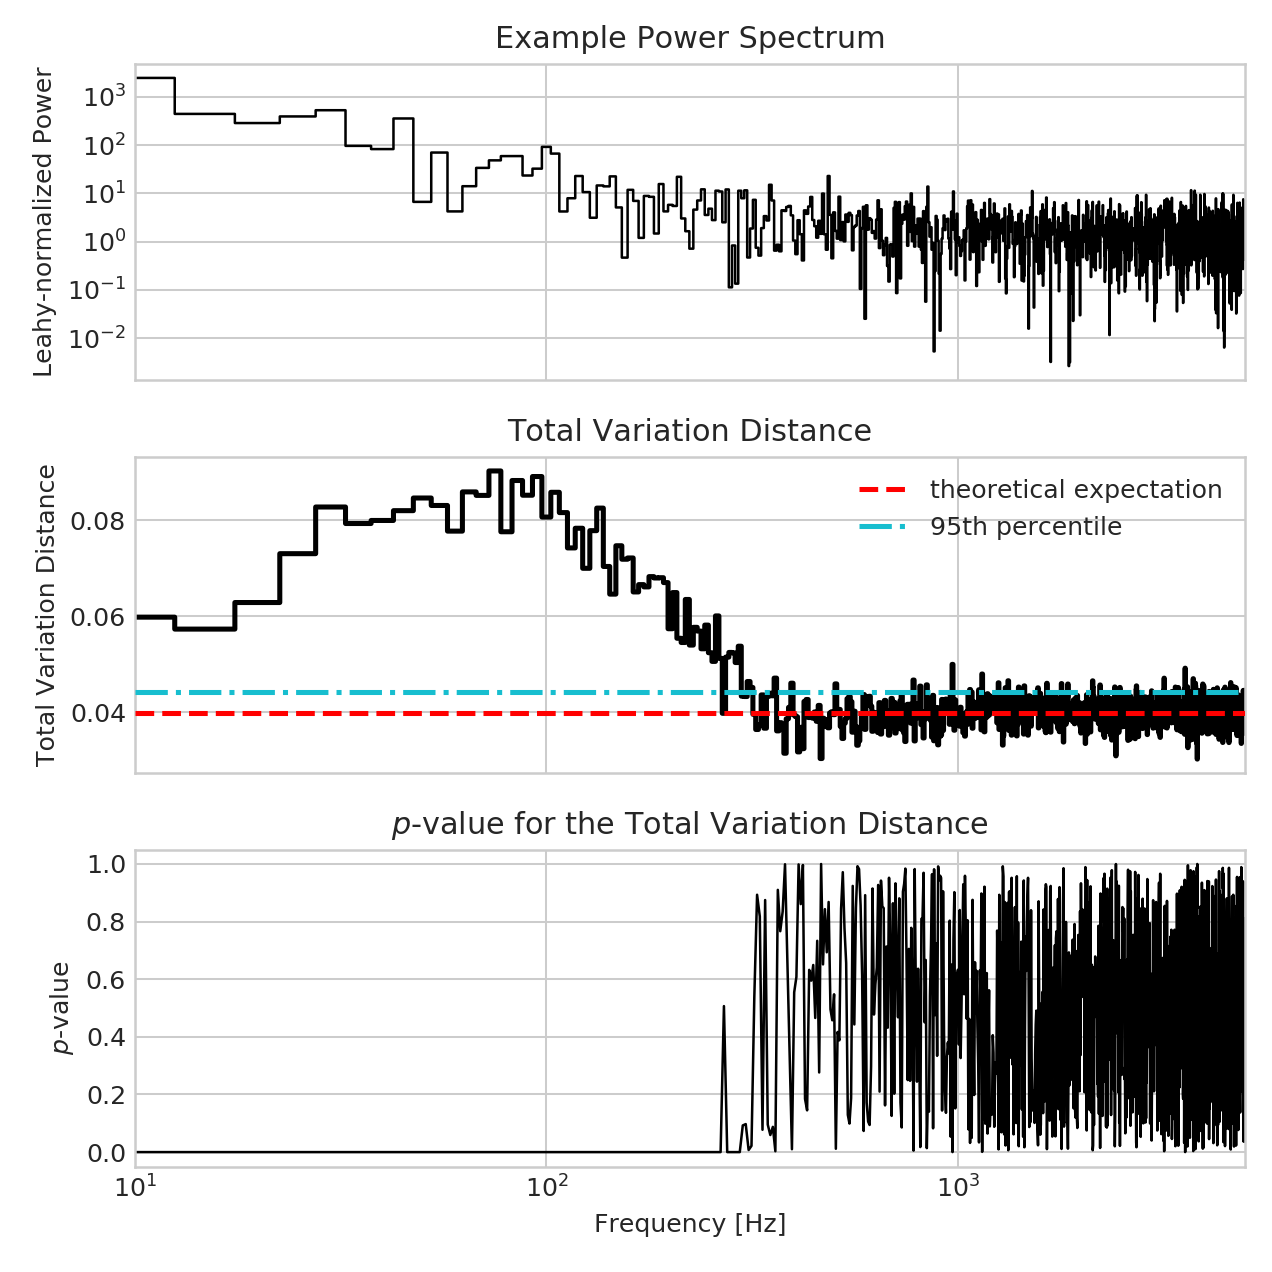

In [852]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7,7), sharex=True)

ax1.loglog(ps1_all[0].freq[1:], ps1_all[1].power[1:], lw=1, color="black", linestyle="steps-mid")
ax1.set_xlim(ps1_all[0].freq[1], ps1_all[0].freq[-1])
ax1.set_ylabel("Leahy-normalized Power")
ax1.set_title("Example Power Spectrum")

ax2.semilogx(ps1_all[0].freq[1:], tvs_csd[1:], lw=2, color="black", linestyle="steps-mid")
ax2.set_title("Total Variation Distance")
ax2.hlines(np.mean(tvs_sims), ps1_all[0].freq[1], ps1_all[0].freq[-1], lw=2, color="red", 
           linestyle="dashed", zorder=10, label="theoretical expectation")
ax2.hlines(np.percentile(tvs_sims, 95),  ps1_all[0].freq[1], ps1_all[0].freq[-1], lw=2,
           color=sns.color_palette()[9], linestyle="-.", zorder=10, label="95th percentile")
ax2.set_ylabel("Total Variation Distance")
ax2.legend()

ax3.semilogx(ps1_all[0].freq[1:], p_tvs[1:], lw=1, color="black")
ax3.set_ylabel(r"$p$-value")
ax3.set_title(r"$p$-value for the Total Variation Distance")

ax3.set_xlabel("Frequency [Hz]")

plt.tight_layout()
plt.savefig("../figs/tvs.pdf", format="pdf")


Let's calculate the p-value that the total variation distance is an outlier with respect to the expected distribution:

Hmm, so this is systematically higher, and depends a lot on the (1) number of bins in the histogram and (2) the number of simulations I have available. I think I need to think about this more!

Maybe we can determine how much it actually matters. Can we calculate the *mean* and the *percentiles* for each distribution?

In [219]:
csd_means = np.mean(csd_normed_all, axis=0)
csd_std = np.std(csd_normed_all, axis=0)

In [255]:
mcov = mcorr_data/mvar_data
cov_test, corr_test, mean_test, std_test = [], [], [], []

for i in range(len(mcov)):
    
    rsim1 = np.random.multivariate_normal([0,0], [[mvar_normed_data[i], mcov[i]], [mcov[i], mvar_normed_data[i]]], size=10000)
    rsim2 = np.random.multivariate_normal([0,0], [[mvar_normed_data[i], mcov[i]], [mcov[i], mvar_normed_data[i]]], size=10000)

    rmult1 = rsim1[:,0] * rsim1[:,1]
    rmult2 = rsim2[:,0] * rsim2[:,1]

    rcov1 = np.cov(rsim1[:,0], rsim1[:,1])
    rcov2 = np.cov(rsim2[:,0], rsim2[:,1])
    corrcoeff1 = np.corrcoef(rsim1[:,0], rsim1[:,1])
    corrcoeff2 = np.corrcoef(rsim2[:,0], rsim2[:,1])

    rmean = (rmult1 + rmult2)/2.

    corr = corrcoeff1[0,1]
    
    cov_test.append(rcov1)
    corr_test.append(corr)
    mean_test.append(np.mean(rmean))
    std_test.append(np.std(rmean))
    

<IPython.core.display.Javascript object>


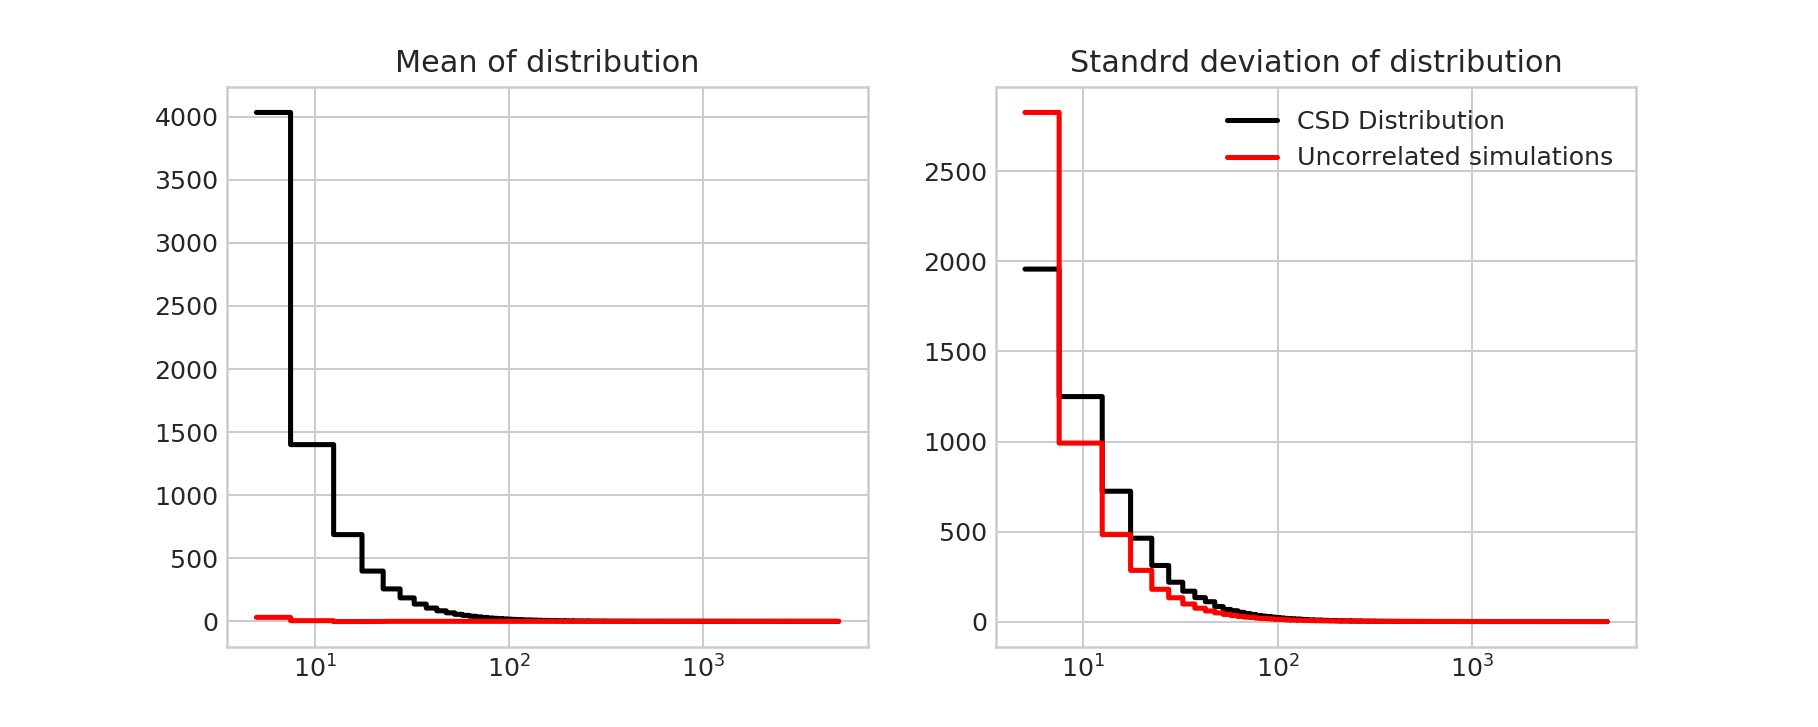

Text(0.5,1,'Standrd deviation of distribution')

In [252]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(10,4))

ax1.semilogx(ps1_all[0].freq, csd_means, lw=2, color="black", 
             linestyle="steps-mid", label="CSD Distribution")
ax1.semilogx(ps1_all[0].freq, mean_test, lw=2, color="red",
            linestyle="steps-mid", label="Uncorrelated simulations")
ax1.set_title("Mean of distribution")

ax2.semilogx(ps1_all[0].freq, csd_std, lw=2, color="black", 
             linestyle="steps-mid", label="CSD Distribution")
ax2.semilogx(ps1_all[0].freq, std_test, lw=2, color="red",
             linestyle="steps-mid", label="Uncorrelated simulations")

ax2.legend()
ax2.set_title("Standrd deviation of distribution")

I think what this means is that I'm seeing the correlation in the means of the distribution?

In [261]:
fourier1_all = np.array(fourier1_all)
fourier2_all = np.array(fourier2_all)

In [289]:
fourier_real = fourier1_all.real * fourier2_all.real
fourier_imag = fourier1_all.imag * fourier2_all.imag
f_comb = fourier_real + fourier_imag
f_comb  = f_comb.real

In [277]:
csd_test = fourier1_all * np.conj(fourier2_all)

In [290]:
f_comb - csd_test.real

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Okay, just a small check that I defined my cross spectrum correctly. Phew. 

Now let's see if I can learn something about the correlation coefficient between the real and imaginary components:

In [294]:
fourier_real.shape

(10000, 999)

In [296]:
np.cov(fourier_real[:,i], fourier_imag[:,i])

array([[ 3.41464236e+16, -1.54824447e+16],
       [-1.54824447e+16,  3.51241858e+16]])

In [297]:
corrcoeff_z = np.zeros(fourier_real.shape[1])
cov_z = np.zeros(fourier_real.shape[1])
for i in range(fourier_real.shape[1]):
    cov_z = np.cov(fourier_real[:,i], fourier_imag[:,i])
    corrcoeff_z[i] = cov_z[0,1]/(np.sqrt(cov_z[0,0]) * np.sqrt(cov_z[1,1]))

<IPython.core.display.Javascript object>


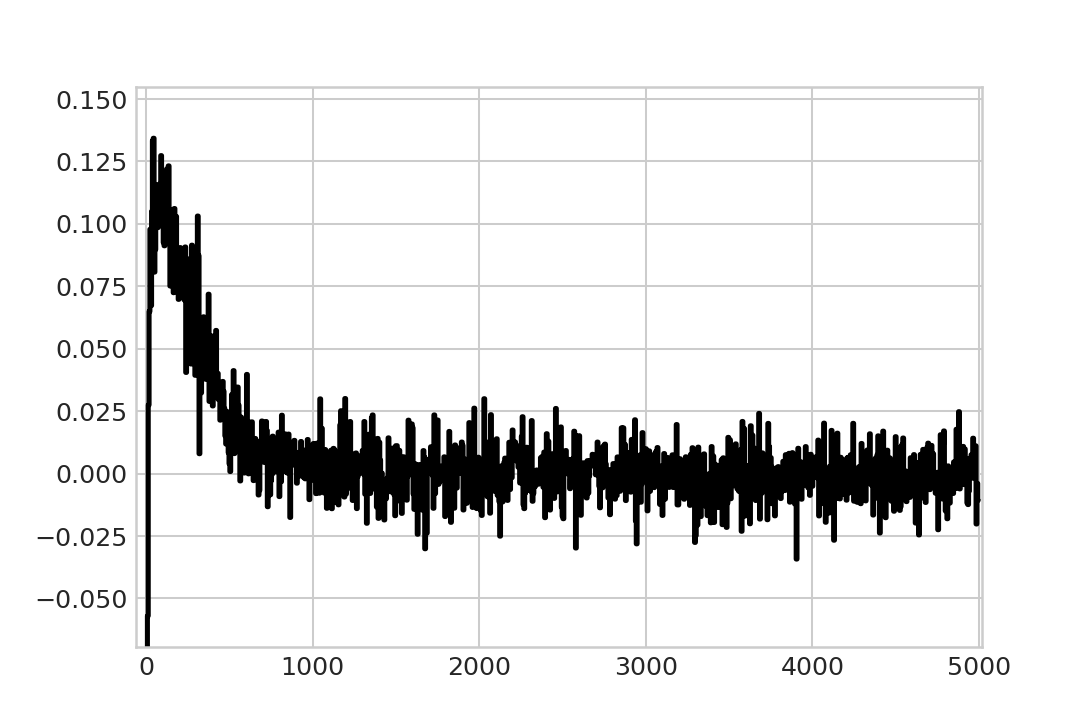

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(ps1_all[0].freq, corrcoeff_z, lw=2, color="black", linestyle="steps-mid")

<IPython.core.display.Javascript object>


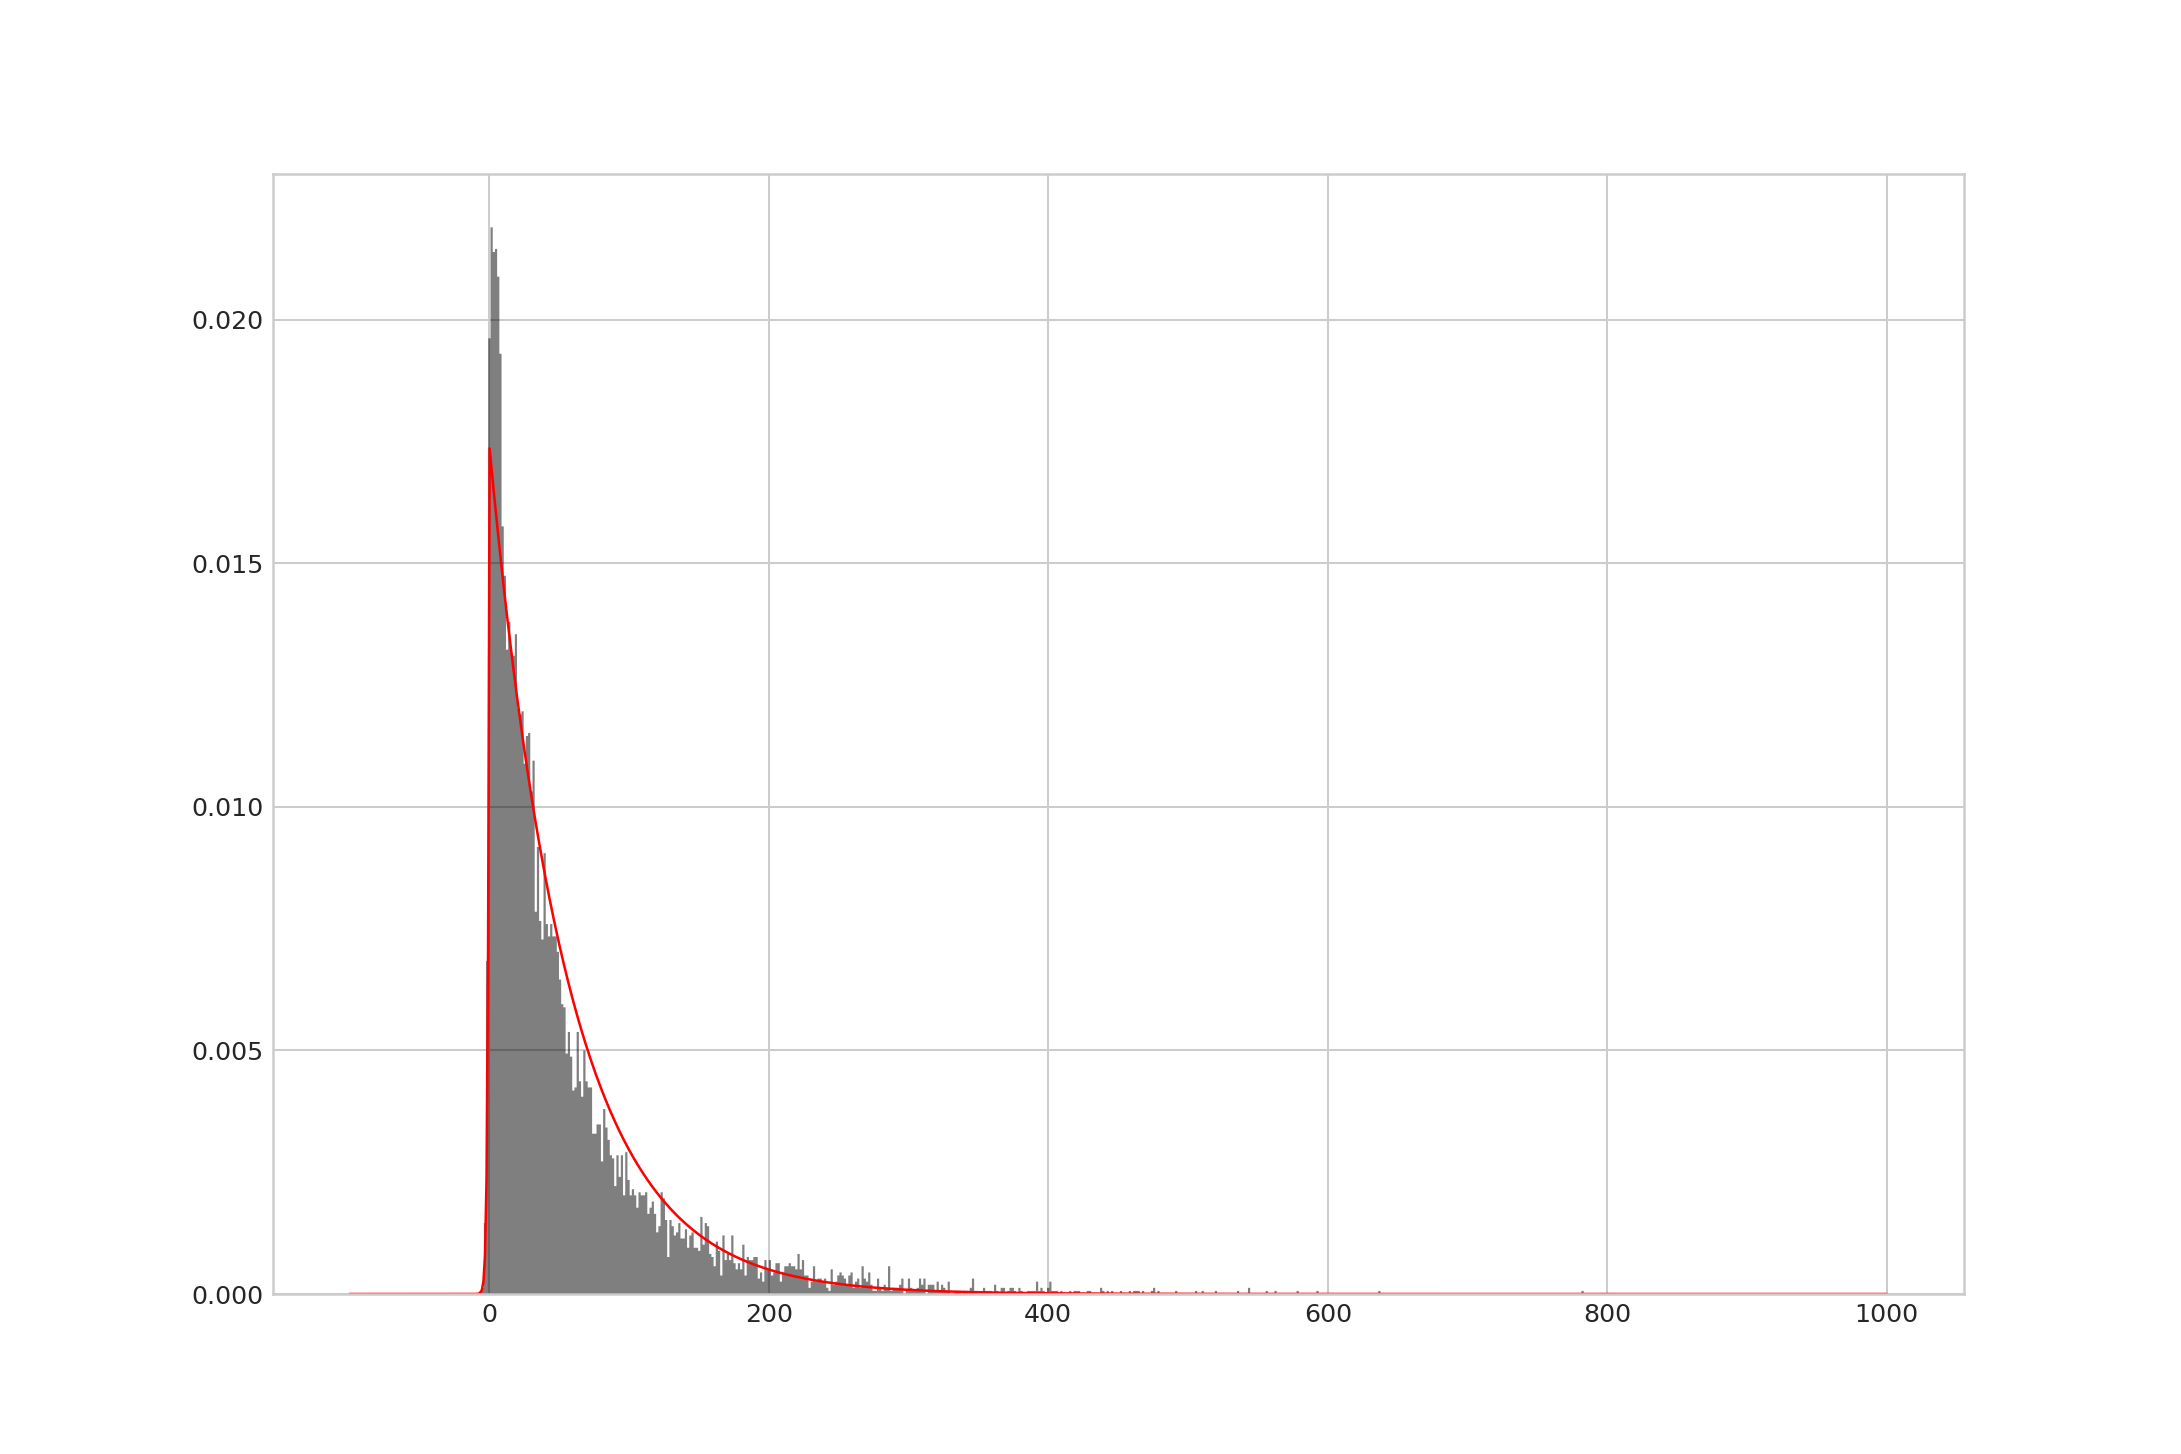

In [306]:
fig, ax1 =plt.subplots(1, 1, figsize=(12, 8))

ax1.hist(csd_normed_all[:,freq_idx1], bins=500, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes", density=True)
ax1.plot(x10, csd_p_10, color="red", lw=1)


Dunno, this all looks difficult!

### The Likelihood

Can I write down an actual likelihood for the cospectrum?

In [70]:
from astropy.modeling.fitting import _fitter_to_model_params

In [71]:
import mpmath

In [486]:
from stingray.modeling import LogLikelihood

In [511]:
class CospectraLogLikelihood(LogLikelihood):
    
    def __init__(self, x, y, model):
        
        self.x = x
        self.y = y
        self.model = model
        self.npar = 0
        for pname in self.model.param_names:
            if not self.model.fixed[pname]:
                self.npar += 1
        
    def _cospectra_prob(self, x, std1, std2, rho, n=2):
        sigma_both = std1 * std2
        rho_coeff = (1 - rho**2.)
        x_abs = np.abs(x)

        first_term_nom = (n+1)/2 * np.log(n) + (1-n)/2. * np.log(2) + (n-1)/2. *  np.log(x_abs)
        first_term_denom = ((n+1)/2.)*np.log(sigma_both) + 0.5 * np.log(np.pi * rho_coeff) + scipy.special.gammaln(n/2.)

        first_term = first_term_nom - first_term_denom

        second_term = rho * n * x / (sigma_both * rho_coeff)

        log_bessel_arg = np.log(n) + np.log(x_abs) -  np.log(sigma_both) - np.log(rho_coeff)
        order = (n - 1) / 2.
        
            
        third_term = np.log(scipy.special.kv(order, np.exp(log_bessel_arg)))
        
        tt_mask = (np.isfinite(third_term))
        
        for i in np.arange(0,len(tt_mask), 1, dtype=int)[~tt_mask]:
            third_term[i] = np.float(mpmath.log(mpmath.besselk(order, 
                                                               np.exp(log_bessel_arg[i]))))

        #print("first term: " + str(first_term))
        #print('second_term: ' + str(second_term))
        #print("third_term: " + str(third_term))
        return first_term + second_term + third_term

        
    def evaluate(self, pars, neg=False):
        
        _fitter_to_model_params(self.model, pars)
        model_spec = self.model(self.x)
        
        mstd = np.sqrt(model_spec + 2.0)
        #print("mstd: " + str(mstd))
        mcorr = model_spec / (model_spec + 2.)
        #print("mcorr: " + str(mcorr))
        
        loglike = np.sum(self._cospectra_prob(self.y, mstd, mstd, mcorr))
        
        if not np.isfinite(loglike):
            loglike = logmin

        if neg:
            return -loglike
        else:
            return loglike
 

In [512]:
csd = csd_normed_all[10]
freq = ps1_all[0].freq[:1500]

In [513]:
cloglike = CospectraLogLikelihood(freq, csd, m_rn)

<IPython.core.display.Javascript object>


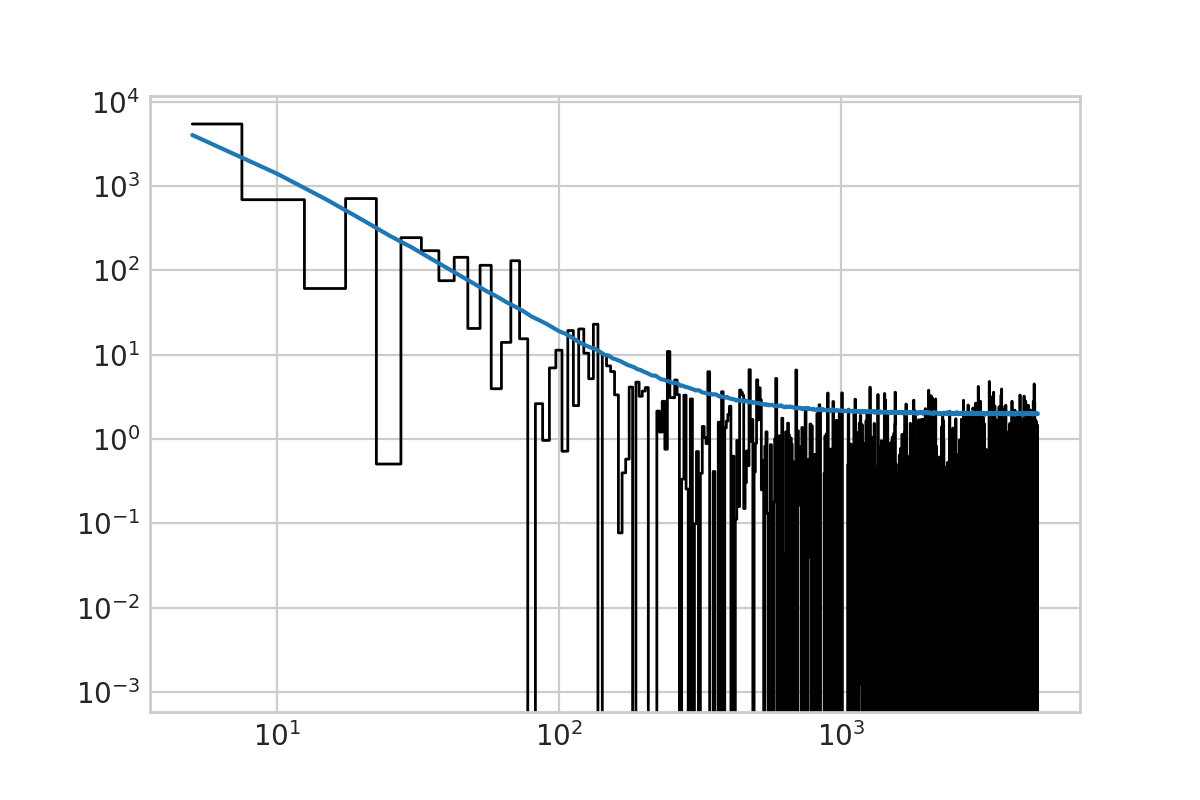

In [514]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.loglog(freq, csd, lw=1, color="black", linestyle="steps-mid")
ax.plot(avg_ps1.freq, avg_ps1.power)

In [515]:
cloglike(true_pars)

-1877.4510971255831

In [505]:
%timeit cloglike(true_pars)

1.1 ms ± 50.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [506]:
test_pars = [1, 1]

In [507]:
cloglike([1,1])

-8679.295355233797

In [494]:
%timeit cloglike([1,1])

1 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So, can we use this to actually fit the data?

In [668]:
lc1_all_test = np.loadtxt("../code/test_pl_nodeadtime_lc1.dat")
lc2_all_test = np.loadtxt("../code/test_pl_nodeadtime_lc2.dat")

time_test = np.loadtxt("../code/test_pl_nodeadtime_time.dat")

<IPython.core.display.Javascript object>


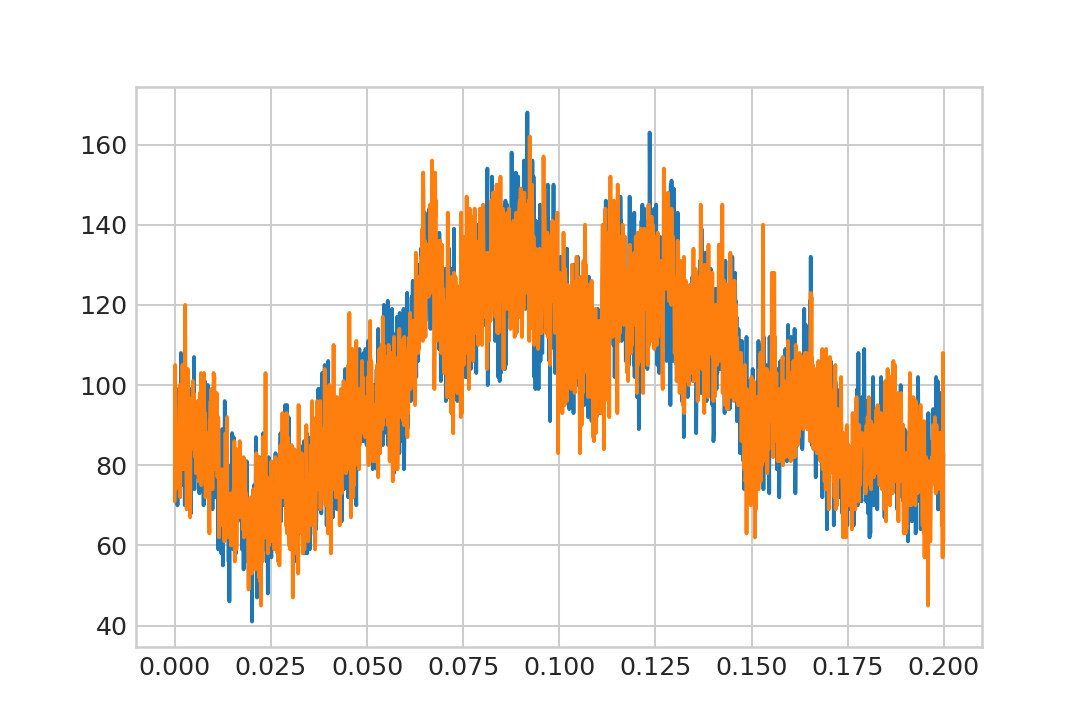

In [670]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time_test, lc1_all_test[0])
ax.plot(time_test, lc2_all_test[0])

In [495]:
from stingray.modeling import PSDParEst

In [564]:
t0 = [26835.78651627, 2.0, 2.0]
t0_cs = [26835.78651627, 2.0, 0.0]

In [565]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

In [682]:
res_all = []

nfits = 10

np.random.seed(200)
random_idx = np.random.choice(np.arange(0, len(lc1_all), 1, dtype=int), 
                              size=nfits, replace=False)

for idx in random_idx:
    lc1 = lc1_all[idx]
    lc2 = lc2_all[idx]
    cs = Crossspectrum(lc1, lc2, norm="leahy")
    parest = PSDParEst(cs, max_post=False)
    cloglike = CospectraLogLikelihood(cs.freq, cs.power, m)
    
    start_idx = 200
    try:
        res = parest.fit(cloglike, t0_cs)
        res_all.append(res)
        #fig, ax = plt.subplots(1, 1, figsize=(6,4))
        #ax.semilogx(cs.freq[start_idx:], cs.power[start_idx:], lw=1, color="black", linestyle="steps-mid", label="data")
        #_fitter_to_model_params(m, res.p_opt)
        #mcounts = m(cs.freq)
        #ax.semilogx(cs.freq[start_idx:], mcounts[start_idx:], lw=2, color="red", label="model fit")
        #ax.set_xlabel("Frequency [Hz]")
        #ax.set_ylabel("Power")
        
    except ValueError:
        continue


Let's also fit the power spectrum with the model in order to figure out 
how the parameters derived are different?

In [568]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

In [569]:
res_all_ps = []

for idx in random_idx:
    lc1 = lc1_all[idx]
    lc2 = lc2_all[idx]

    lc_sum = lc1 + lc2
    ps = Powerspectrum(lc_sum, norm="leahy")
    
    parest = PSDParEst(ps, max_post=False)
    ploglike = PSDLogLikelihood(ps.freq, ps.power, m)
    
    try:
        res = parest.fit(ploglike, t0)
        res_all_ps.append(res)
    except ValueError:
        continue

Now let's plot the two distributions:

In [570]:
res_all = np.array(res_all)
res_all_ps = np.array(res_all_ps)

In [571]:
p_opt_cs = np.array([res.p_opt for res in res_all])
p_opt_ps = np.array([res.p_opt for res in res_all_ps])

In [572]:
min_hist = np.min(np.hstack([p_opt_cs[:,1], p_opt_ps[:,1]]))
max_hist = np.max(np.hstack([p_opt_cs[:,1], p_opt_ps[:,1]]))

<IPython.core.display.Javascript object>


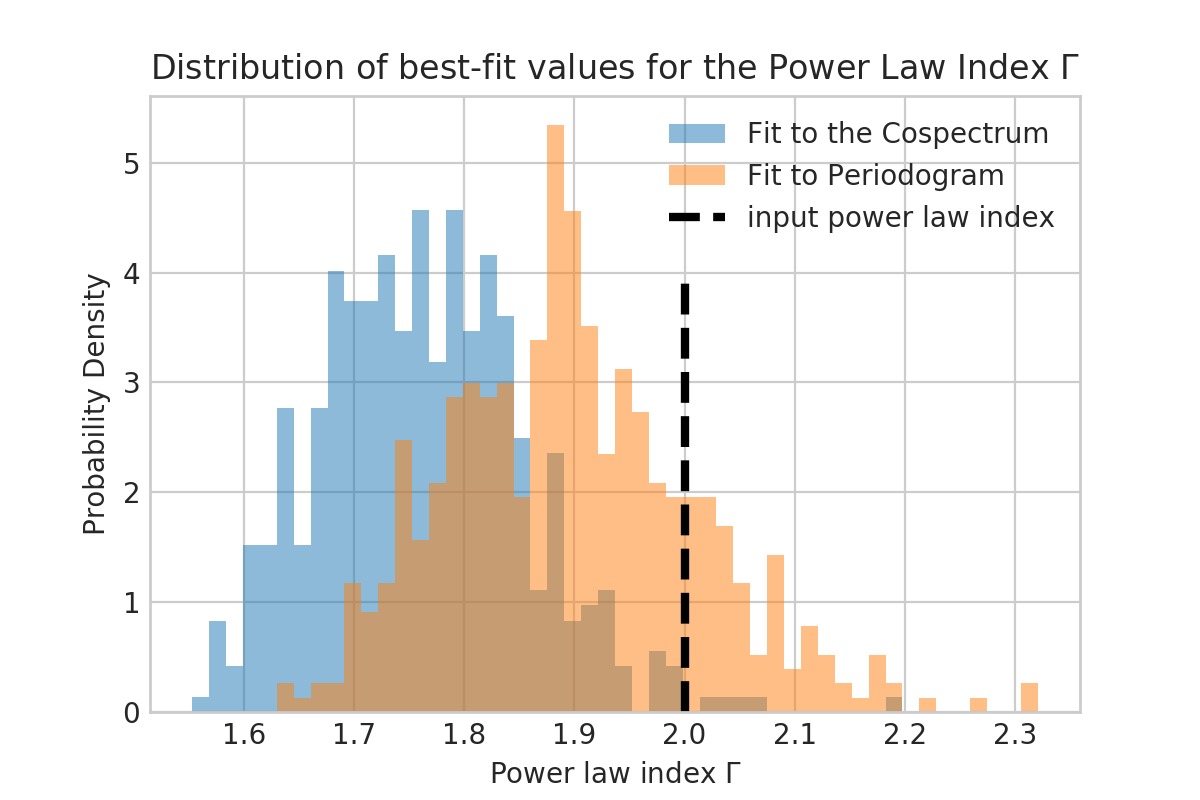

Text(0,0.5,'Probability Density')

In [580]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(p_opt_cs[:,1], bins=50, range=[min_hist, max_hist], 
         histtype="stepfilled", color=sns.color_palette()[0], 
        alpha=0.5, label="Fit to the Cospectrum", normed=True)
ax.hist(p_opt_ps[:,1], bins=50, range=[min_hist, max_hist],
        histtype="stepfilled", color=sns.color_palette()[1],
        alpha=0.5, label="Fit to Periodogram", normed=True)

ax.vlines(2.0, 0, 4, color="black", lw=3, 
          linestyle="dashed", label="input power law index")
ax.legend()
ax.set_title(r"Distribution of best-fit values for the Power Law Index $\Gamma$")
ax.set_xlabel(r"Power law index $\Gamma$")
ax.set_ylabel("Probability Density")

Looks like the likelihood is systematically biased compared to the true underlying PSD.

In [673]:
min_hist = np.min(np.hstack([p_opt_cs[:,0], p_opt_ps[:,0]]))
max_hist = np.max(np.hstack([p_opt_cs[:,0], p_opt_ps[:,0]]))

In [675]:
p_opt_cs[:,0]

array([ 67707.12609488,  90469.99618784,  49906.77509706,  26827.20920779,
        72684.47584469,  26855.11943491,  26826.51522226,  46877.897751  ,
        26846.13606603,  59151.55454274,  99337.13613758,  26822.78675751,
        26829.36986369,  26809.51922563,  64268.59649033,  87001.10999123,
        62059.72815993,  60094.42741347,  26820.69280092,  54421.79521474,
        26900.07984715,  26848.5625008 ,  78475.09516436,  30807.33001077,
        49879.89804161,  27335.36976318,  58949.75577222,  26837.67074027,
        26830.53700007,  32829.44992568,  26818.20357124,  38728.60600525,
       117881.25534317,  92138.1132685 , 136663.63537931,  92329.35215972,
        33240.13797391,  26833.44751765,  40134.90577254,  98227.81776066,
        80154.82505781,  26847.44800742,  26828.31726029,  26838.20575904,
        26852.84956577,  47875.81168841,  26835.39259648,  26837.98934183,
        26823.42005182,  26819.83714464,  39541.94443604,  26822.84917786,
        67459.69851242,  

<IPython.core.display.Javascript object>


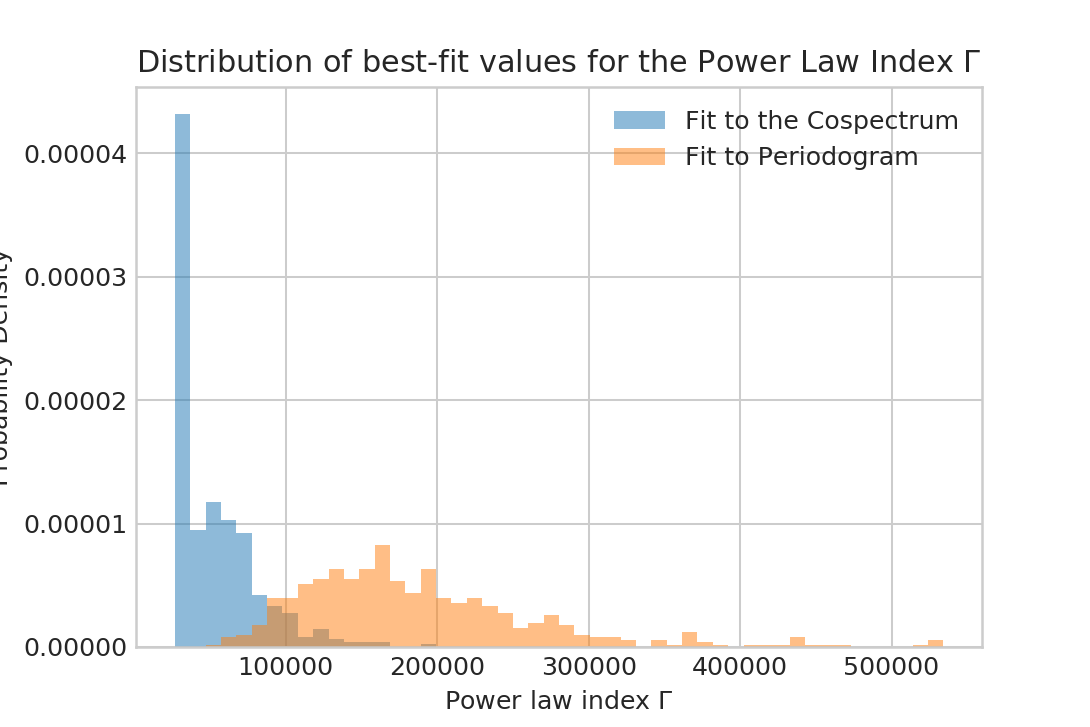

Text(0,0.5,'Probability Density')

In [677]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(p_opt_cs[:,0], bins=50, range=[min_hist, max_hist], 
         histtype="stepfilled", color=sns.color_palette()[0], 
        alpha=0.5, label="Fit to the Cospectrum", normed=True)
ax.hist(p_opt_ps[:,0], bins=50, range=[min_hist, max_hist],
        histtype="stepfilled", color=sns.color_palette()[1],
        alpha=0.5, label="Fit to Periodogram", normed=True)

#ax.vlines(2.0, 0, 4, color="black", lw=3, 
#          linestyle="dashed", label="input power law index")
ax.legend()
ax.set_title(r"Distribution of best-fit values for the Power Law Index $\Gamma$")
ax.set_xlabel(r"Power law index $\Gamma$")
ax.set_ylabel("Probability Density")

## Approximate Bayesian Computation

**TODO**: If I can't write down a likelihood, maybe I can do this with ABC???

Plus: can also take all things done to the data into account, including dead time! :D :D :D 


## Averaged Cospectra

What about averaged cospectra? At a certain point, they're going to be approximately Gaussian again, but I'm not quite sure when (**TODO**: figure out how many data sets I should average to get approximately normally distributed powers). 

However, I *think* the equation above should also work for averaged cospectra. Recall that Equation 2 from Theorem 1 of the Gault (2018) paper describes the probability distribution of the sample mean of $N$ random variables with the same distribution as $Z$,

$$
\bar{Z} = Z_1 + Z_2 + ... + Z_N$ 
$$

Averaged cospectra are constructed by taking indidual cospectra and averaging them together. That means that the distribution of an averaged cospectrum created from $N$ individual spectra should be that of $2N$ variables $Z$, i.e.

$$
C_{\mathrm{avg}} = \frac{1}{N}(C_1 + C_2 + ... + C_N) = \frac{1}{2N}[\frac{1}{2}(Z_1 + Z_2) + \frac{1}{2} (Z_3 + Z_4) + ... + \frac{1}{2}(Z_{2N-1} + Z_{2N})]
$$

and hence we can use the same distribution as for the single cospectrum.

We can actually also use the *same function* as before, since that includes a parameter $n$ for the number of spectra:


In [84]:
csd_all.shape

(10000, 999)

In [85]:
n_spectra = 5 # number of cospectra per averaged spectrum
n_csd = int(csd_all.shape[0]/n_spectra) # total number of simulated averaged cospectra

In [86]:
csd_avg = np.zeros((n_csd, csd_all.shape[1]))

for i in range(n_csd):
    csd_avg[i] = np.sum(csd_all[n_spectra*i:n_spectra*(i+1)], axis=0)/(n_spectra)

<IPython.core.display.Javascript object>


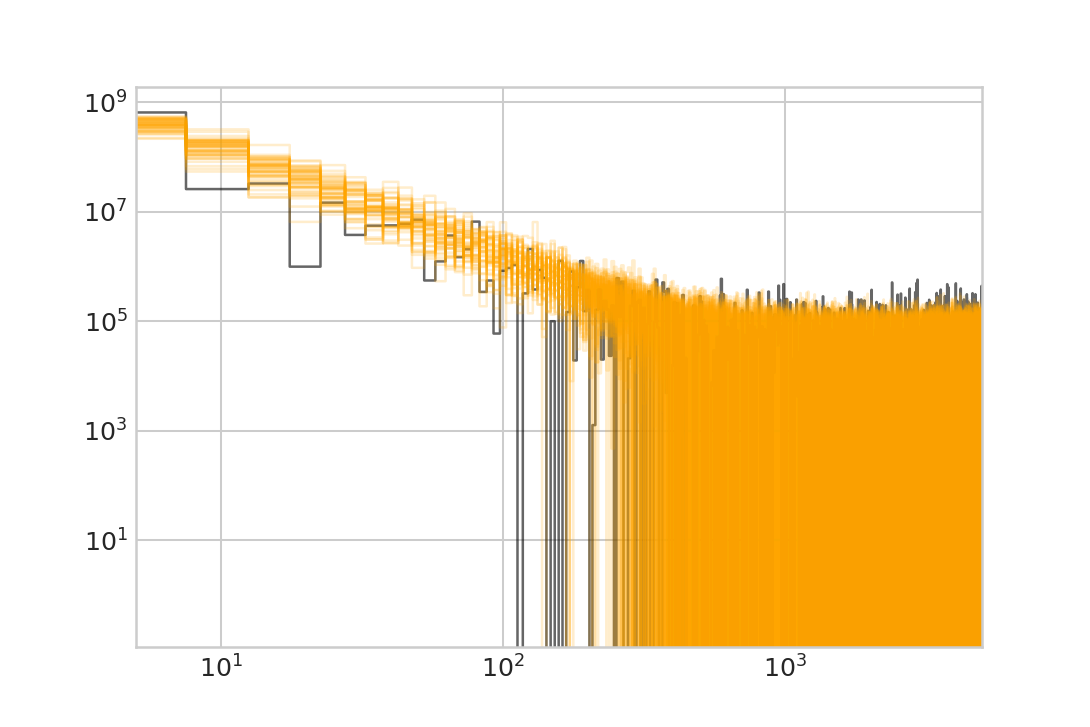

(4.999999999999857, 4994.999999999857)

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.loglog(freq, csd_all[0], lw=1, color="black", linestyle="steps-mid", alpha=0.6)

ax.plot(freq, csd_avg[:50,:].T, lw=1, color="orange", linestyle="steps-mid", alpha=0.2);
ax.set_xlim(freq[0], freq[-1])


**TODO**: Check whether that distribution is actually right, or whether the spectra skew high? Looks all right, I think, but might merit further checks.

What's the distribution of some of these powers?

In [88]:
csd_avg.shape

(2000, 999)

In [89]:
csd_avg = 2.*csd_avg/np.mean(lc1_counts_all)

In [91]:
x10 = np.linspace(np.min(csd_avg[:,freq_idx1]), np.max(csd_avg[:,freq_idx1]), 10000)
x100 = np.linspace(np.min(csd_avg[:,freq_idx2]), np.max(csd_avg[:,freq_idx2]), 10000)
x1000 = np.linspace(np.min(csd_avg[:,freq_idx3]), np.max(csd_avg[:,freq_idx3]), 10000)

csd_p_10 = mean_corr_prob(x10, np.sqrt(mvar_normed_data[freq_idx1]), np.sqrt(mvar_normed_data[freq_idx1]), 
                          mcorr_data[freq_idx1], n=2*n_spectra)
csd_p_100 = mean_corr_prob(x100, np.sqrt(mvar_normed_data[freq_idx2]), np.sqrt(mvar_normed_data[freq_idx2]), 
                           mcorr_data[freq_idx2], n=2*n_spectra)
csd_p_1000 = mean_corr_prob(x1000, np.sqrt(mvar_normed_data[freq_idx3]), np.sqrt(mvar_normed_data[freq_idx3]), 
                            mcorr_data[freq_idx3], n=2*n_spectra)

<IPython.core.display.Javascript object>


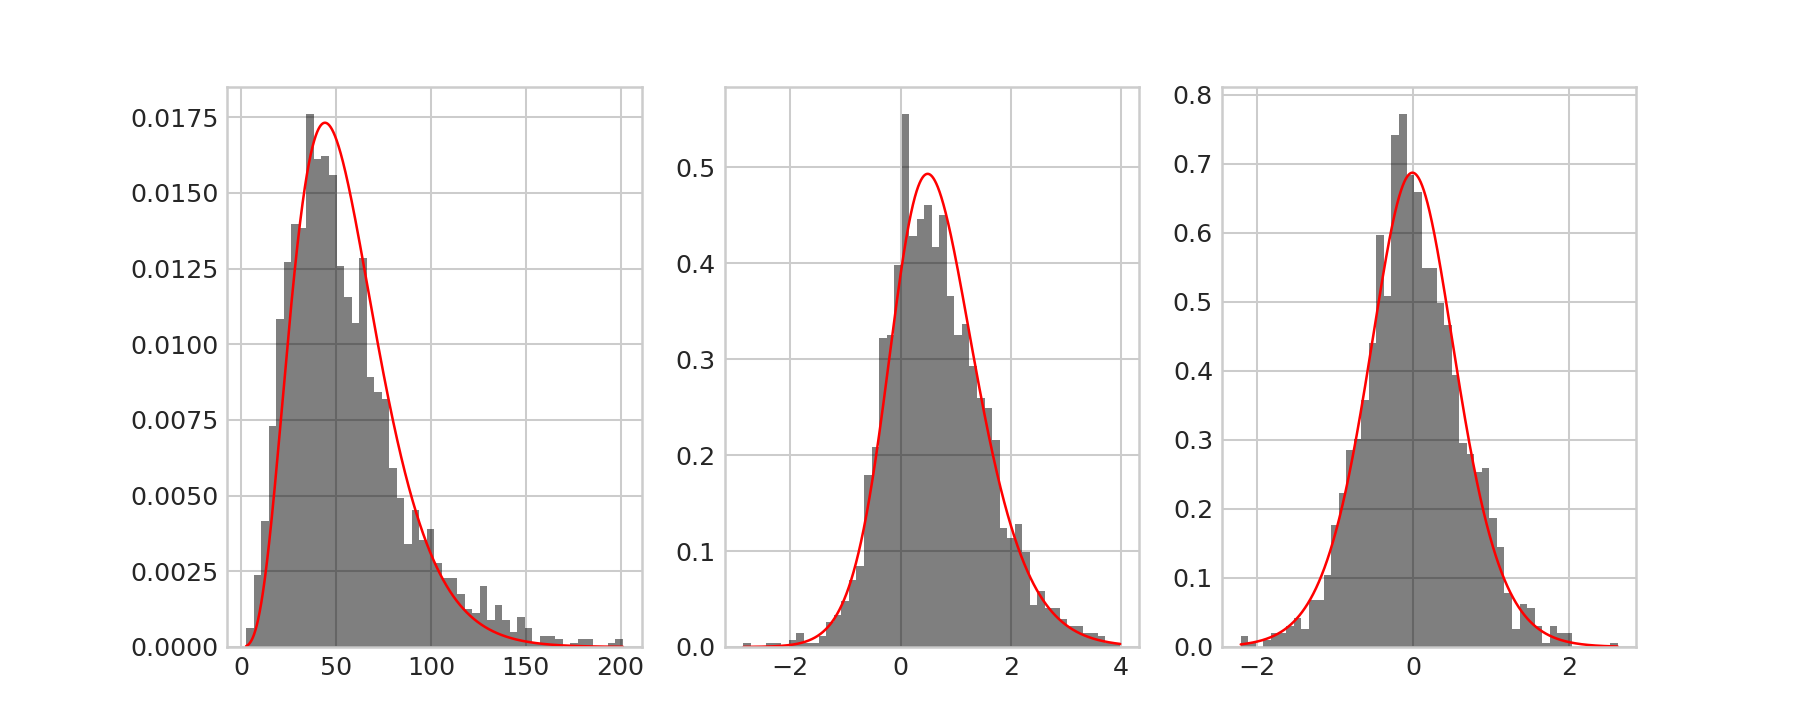

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(csd_avg[:,freq_idx1], bins=50, histtype="stepfilled", color="black", 
         alpha=0.5, label="Real Fourier amplitudes", density=True)
ax1.plot(x10, csd_p_10, color="red", lw=1)

ax2.hist(csd_avg[:,freq_idx2], bins=50, histtype="stepfilled", color="black", 
         alpha=0.5, density=True)
ax2.plot(x100, csd_p_100, color="red", lw=1)

ax3.hist(csd_avg[:,freq_idx3], bins=50, histtype="stepfilled", color="black", 
         alpha=0.5, density=True);
ax3.plot(x1000, csd_p_1000, color="red", lw=1)



Hmm, I'm not sure this is working, especially not for the cases with high correlation (i.e. a lot of power).

## Moment-Generating Functions

The moment-generating function for two correlated Gaussian variables can be written as 

$$
M_{XY}(t) = \frac{\exp{\left(\frac{\alpha_x^2 + \alpha_y^2 - 2\rho\alpha_x\alpha_y)t^2 + 2\alpha_x \alpha_y t}{2[1 - (1+\rho)t][1+(1-\rho)t]} \right)}}{\sqrt{[1-(1+\rho)t][1+(1-\rho)t]}}
$$

Where $\alpha_x = \mu_x / \sigma_x$ and $\alpha_y = \mu_y / \sigma_y$, and $\rho$ is the correlation coefficient.

For our case, $\alpha_x = \alpha_y = 0$, and hence

$$
M_{XY} = \frac{1}{\sqrt{[1-(1+\rho)t][1+(1-\rho)t]}}
$$

The sum of two (independent? Need to check!) random variables can be written as the product of their moment-generating function. For our case, we will add two random variables with the same probability distribution, so that the product becomes

$$
M_{XY} = \frac{1}{[1-(1+\rho)t][1+(1-\rho)t]}
$$

With a slight change in notation, we have

$$
M_{XY} = \frac{1}{[1-(1+\rho)t][1-(\rho-1)t]}
$$

where now the two individual terms correspond to a Gamma-distribution, defined as 

$$
p(x | \theta, k) = \frac{1}{\Gamma(k)\theta^k}x^{k-1} e^{-x/\theta}
$$

with a moment-generating function

$$
M(t) = \frac{1}{(1-\beta t)^{-\alpha}} \; .
$$

In our case, thus, the moment-generating function consists of the product of the moment generating functions of two Gamma-distributions, with $k_1 = k_2 = 1$, $\beta_1 = 1+ \rho$ and $\beta_2 = \rho -1$.

In [Moschopoulos (1985)](http://www.springerlink.com/index/m632768u76821777.pdf), the distribution of the sum of two independent Gamma-distributed random variables is described. Now our variables are *not* independent, but let's deal with that later. 

The exact density is described in Equation 9 as 

$$
f(x) = C \sum_{k=0}^{\infty}{\frac{\delta_k x^{\tau+k-1} e^{-x/\beta_1}}{\Gamma(\rho + k) \beta_1^{\tau+k}}} \; ,
$$

Where $\gamma = \sum_{i=1}^{n}\alpha_i$ is the sum of the exponents of the Gamma-distributions, 

$$
\delta_k+1 = \frac{1}{k+1}\sum_{i=1}^{k+1}(i\gamma_i \delta_{k+1-i}) \; ,
$$

with $\delta_0 = 1$, disand 

$$
C = \prod_{i=1}^{n} (\beta_1/\beta_i)^\alpha_i \; .
$$

is the product of the ratio of the smallest $\beta$-parameter, $\beta_1 = \mathrm{min}_i(\beta_i)$, and the $\beta$-parameter of each random variable in the product.

Finally, $\gamma_k$ is defined as

$$
\gamma_k = \sum_{i=1}^{n}{\frac{\alpha_i (1-\beta_1/\beta_i)^k}{k}}
$$

For the cospectrum, we assume that Fourier amplitudes are essentially always either positively correlated or not correlated, and thus $\beta_1 = \rho - 1$. Similarly we have said above that $\alpha_i = 1$.

Hence we get 

$$
\gamma_k = \sum_{i=1}^{n}{\frac{(1-(\rho-1)/\beta_i)^k}{k}} = \frac{{(1-(\rho -1)/(\rho + 1))^k}}{k} = \frac{\left(\frac{2}{\rho+1}\right)^k}{k}
$$

as well as $\tau = \sum_{1}^{2}(1) = 2$ and $C = \frac{\rho-1}{\rho+1}$. 

Let's first code up the function for $\delta_k+1$:

In [93]:
k = 4

In [98]:
k_all = np.arange(1,k+1,1, dtype=int)

In [99]:
k_all

array([1, 2, 3, 4])

In [100]:
k_all[::-1]

array([4, 3, 2, 1])

In [ ]:
gamma = (2/(2+rho))**k[::-1]

In [136]:
def delta_term(k, rho):
    
    k_all = np.arange(1,k+1,1, dtype=int)
    
    delta_0 = 1.0
    
    delta_all = np.zeros(k+1)
    delta_all[0] = delta_0
    
    gamma = ((2/(1+rho))**k_all[::-1])/k_all[::-1]
    print(gamma)
    
    for i in k_all:
        delta_all[i] = np.sum(gamma[-i:] * delta_all[:i] * k_all[:i])
        
    print(delta_all)
        
    return delta_all[-1]

In [140]:
k_all[::-1]

array([4, 3, 2, 1])

In [137]:
rho = 0.5
k=2

delta_term(k, rho)

[0.88888889 1.33333333]
[1.         1.33333333 4.44444444]


4.444444444444445

In [126]:
(2/1.5)**2.

1.7777777777777777

In [131]:
4/(1.5**2.)

1.7777777777777777